In [13]:
%pylab inline
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from IPython import display
rcParams.update({'figure.max_open_warning': 0})
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# solve_ivp functions

# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xs,K,koff,a0):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Ac = y[1:N+1]          # bound complex on lattice
    As = y[-N:]             # unbound complex on lattice
    
    dxdt = integrate.trapz(-(x0-xs)*Ac, x=xs)
    binding = exp(-0.5*(x0-xs)**2)*As 
    burnt = nu*Ac
    rebinding = koff/(1+K)*a0-koff*As

    dAcdt = (binding - burnt)
    dAsdt = -binding +rebinding
    
    return array( [dxdt] + list(dAcdt) + list(dAsdt))

In [3]:
# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 20.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied

In [7]:
# use solve_ivp to find solution from t0=0 up to a max tf= 400, but stop if x hits x=20.0

tf = 500.0

dGs = array([1,4,7])
dG_n = len(dGs)

# define domain and lattice
Lmax = 30.0
Lmin = -5.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0s = logspace(-2,3,41, base = 10)
a0_n = len(a0s)
nus = logspace(-2,3,41, base = 10)
nu_n = len(nus)


print(a0s)

[1.00000000e-02 1.33352143e-02 1.77827941e-02 2.37137371e-02
 3.16227766e-02 4.21696503e-02 5.62341325e-02 7.49894209e-02
 1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.00000000e+01 1.33352143e+01 1.77827941e+01 2.37137371e+01
 3.16227766e+01 4.21696503e+01 5.62341325e+01 7.49894209e+01
 1.00000000e+02 1.33352143e+02 1.77827941e+02 2.37137371e+02
 3.16227766e+02 4.21696503e+02 5.62341325e+02 7.49894209e+02
 1.00000000e+03]


In [5]:

#I.C.

vs = []  # record final speed and burn rate
burnt = []
A = []

for dG in dGs:
    K = exp(-dG)
    koff = K

    vtmp1 = []
    btmp1 = []
    Atmp1 = []
    print(a0s,nus)
    for a0 in a0s:
        astdy = a0/(1+koff)
        A0x = linspace(astdy,-astdy*5, Nx)
        A0x[xs>=0.0] = astdy

        # iterate over params
        vtmp2 = []
        btmp2 = []
        Atmp2 = []
        for nu in nus:
            print(a0, nu)

            x0 = 0.0
            Ax = 1.0*A0x
            Acx = zeros(Nx)

            # initial conditions for all the equations, y0
            y0 = array([x0] + list(Acx) + list(Ax))

            sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xs,K,koff,a0), (0., tf), y0, events=[event], method='BDF')

            speed = derivs(sol.t[-1], sol.y[:,-1], nu, xs,K,koff,a0)[0]  #dx/dt
            vtmp2.append(speed)

            Acxf = sol.y[1:1+Nx,-1]  # final amount of complex
            btot = integrate.trapz(nu*Acxf, x=xs)    # total rate of burnt at final time 
            btmp2.append(btot)
            Atmp2.append(sol.y[1:])

        vtmp1.append(vtmp2)
        btmp1.append(btmp2)
        Atmp1.append(Atmp2)
    vs.append(vtmp1)
    burnt.append(btmp1)
    A.append(Atmp1)
vs = array(vs)
burnt = array(burnt)

[1.00000000e-02 1.33352143e-02 1.77827941e-02 2.37137371e-02
 3.16227766e-02 4.21696503e-02 5.62341325e-02 7.49894209e-02
 1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.00000000e+01 1.33352143e+01 1.77827941e+01 2.37137371e+01
 3.16227766e+01 4.21696503e+01 5.62341325e+01 7.49894209e+01
 1.00000000e+02 1.33352143e+02 1.77827941e+02 2.37137371e+02
 3.16227766e+02 4.21696503e+02 5.62341325e+02 7.49894209e+02
 1.00000000e+03] [1.00000000e-02 1.33352143e-02 1.77827941e-02 2.37137371e-02
 3.16227766e-02 4.21696503e-02 5.62341325e-02 7.49894209e-02
 1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.0000

0.03162277660168379 1000.0
0.042169650342858224 0.01
0.042169650342858224 0.01333521432163324
0.042169650342858224 0.01778279410038923
0.042169650342858224 0.023713737056616554
0.042169650342858224 0.03162277660168379
0.042169650342858224 0.042169650342858224
0.042169650342858224 0.05623413251903491
0.042169650342858224 0.07498942093324558
0.042169650342858224 0.1
0.042169650342858224 0.1333521432163324
0.042169650342858224 0.1778279410038923
0.042169650342858224 0.23713737056616552
0.042169650342858224 0.31622776601683794
0.042169650342858224 0.4216965034285822
0.042169650342858224 0.5623413251903491
0.042169650342858224 0.7498942093324559
0.042169650342858224 1.0
0.042169650342858224 1.333521432163324
0.042169650342858224 1.7782794100389228
0.042169650342858224 2.371373705661655
0.042169650342858224 3.1622776601683795
0.042169650342858224 4.216965034285822
0.042169650342858224 5.623413251903491
0.042169650342858224 7.498942093324558
0.042169650342858224 10.0
0.042169650342858224 13.3

0.1778279410038923 316.22776601683796
0.1778279410038923 421.6965034285823
0.1778279410038923 562.341325190349
0.1778279410038923 749.8942093324558
0.1778279410038923 1000.0
0.23713737056616552 0.01
0.23713737056616552 0.01333521432163324
0.23713737056616552 0.01778279410038923
0.23713737056616552 0.023713737056616554
0.23713737056616552 0.03162277660168379
0.23713737056616552 0.042169650342858224
0.23713737056616552 0.05623413251903491
0.23713737056616552 0.07498942093324558
0.23713737056616552 0.1
0.23713737056616552 0.1333521432163324
0.23713737056616552 0.1778279410038923
0.23713737056616552 0.23713737056616552
0.23713737056616552 0.31622776601683794
0.23713737056616552 0.4216965034285822
0.23713737056616552 0.5623413251903491
0.23713737056616552 0.7498942093324559
0.23713737056616552 1.0
0.23713737056616552 1.333521432163324
0.23713737056616552 1.7782794100389228
0.23713737056616552 2.371373705661655
0.23713737056616552 3.1622776601683795
0.23713737056616552 4.216965034285822
0.23

1.0 31.622776601683793
1.0 42.169650342858226
1.0 56.23413251903491
1.0 74.98942093324558
1.0 100.0
1.0 133.3521432163324
1.0 177.82794100389228
1.0 237.13737056616552
1.0 316.22776601683796
1.0 421.6965034285823
1.0 562.341325190349
1.0 749.8942093324558
1.0 1000.0
1.333521432163324 0.01
1.333521432163324 0.01333521432163324
1.333521432163324 0.01778279410038923
1.333521432163324 0.023713737056616554
1.333521432163324 0.03162277660168379
1.333521432163324 0.042169650342858224
1.333521432163324 0.05623413251903491
1.333521432163324 0.07498942093324558
1.333521432163324 0.1
1.333521432163324 0.1333521432163324
1.333521432163324 0.1778279410038923
1.333521432163324 0.23713737056616552
1.333521432163324 0.31622776601683794
1.333521432163324 0.4216965034285822
1.333521432163324 0.5623413251903491
1.333521432163324 0.7498942093324559
1.333521432163324 1.0
1.333521432163324 1.333521432163324
1.333521432163324 1.7782794100389228
1.333521432163324 2.371373705661655
1.333521432163324 3.16227766

5.623413251903491 3.1622776601683795
5.623413251903491 4.216965034285822
5.623413251903491 5.623413251903491
5.623413251903491 7.498942093324558
5.623413251903491 10.0
5.623413251903491 13.33521432163324
5.623413251903491 17.78279410038923
5.623413251903491 23.71373705661655
5.623413251903491 31.622776601683793
5.623413251903491 42.169650342858226
5.623413251903491 56.23413251903491
5.623413251903491 74.98942093324558
5.623413251903491 100.0
5.623413251903491 133.3521432163324
5.623413251903491 177.82794100389228
5.623413251903491 237.13737056616552
5.623413251903491 316.22776601683796
5.623413251903491 421.6965034285823
5.623413251903491 562.341325190349
5.623413251903491 749.8942093324558
5.623413251903491 1000.0
7.498942093324558 0.01
7.498942093324558 0.01333521432163324
7.498942093324558 0.01778279410038923
7.498942093324558 0.023713737056616554
7.498942093324558 0.03162277660168379
7.498942093324558 0.042169650342858224
7.498942093324558 0.05623413251903491
7.498942093324558 0.07

31.622776601683793 10.0
31.622776601683793 13.33521432163324
31.622776601683793 17.78279410038923
31.622776601683793 23.71373705661655
31.622776601683793 31.622776601683793
31.622776601683793 42.169650342858226
31.622776601683793 56.23413251903491
31.622776601683793 74.98942093324558
31.622776601683793 100.0
31.622776601683793 133.3521432163324
31.622776601683793 177.82794100389228
31.622776601683793 237.13737056616552
31.622776601683793 316.22776601683796
31.622776601683793 421.6965034285823
31.622776601683793 562.341325190349
31.622776601683793 749.8942093324558
31.622776601683793 1000.0
42.169650342858226 0.01
42.169650342858226 0.01333521432163324
42.169650342858226 0.01778279410038923
42.169650342858226 0.023713737056616554
42.169650342858226 0.03162277660168379
42.169650342858226 0.042169650342858224
42.169650342858226 0.05623413251903491
42.169650342858226 0.07498942093324558
42.169650342858226 0.1
42.169650342858226 0.1333521432163324
42.169650342858226 0.1778279410038923
42.16

177.82794100389228 13.33521432163324
177.82794100389228 17.78279410038923
177.82794100389228 23.71373705661655
177.82794100389228 31.622776601683793
177.82794100389228 42.169650342858226
177.82794100389228 56.23413251903491
177.82794100389228 74.98942093324558
177.82794100389228 100.0
177.82794100389228 133.3521432163324
177.82794100389228 177.82794100389228
177.82794100389228 237.13737056616552
177.82794100389228 316.22776601683796
177.82794100389228 421.6965034285823
177.82794100389228 562.341325190349
177.82794100389228 749.8942093324558
177.82794100389228 1000.0
237.13737056616552 0.01
237.13737056616552 0.01333521432163324
237.13737056616552 0.01778279410038923
237.13737056616552 0.023713737056616554
237.13737056616552 0.03162277660168379
237.13737056616552 0.042169650342858224
237.13737056616552 0.05623413251903491
237.13737056616552 0.07498942093324558
237.13737056616552 0.1
237.13737056616552 0.1333521432163324
237.13737056616552 0.1778279410038923
237.13737056616552 0.23713737

1000.0 1.7782794100389228
1000.0 2.371373705661655
1000.0 3.1622776601683795
1000.0 4.216965034285822
1000.0 5.623413251903491
1000.0 7.498942093324558
1000.0 10.0
1000.0 13.33521432163324
1000.0 17.78279410038923
1000.0 23.71373705661655
1000.0 31.622776601683793
1000.0 42.169650342858226
1000.0 56.23413251903491
1000.0 74.98942093324558
1000.0 100.0
1000.0 133.3521432163324
1000.0 177.82794100389228
1000.0 237.13737056616552
1000.0 316.22776601683796
1000.0 421.6965034285823
1000.0 562.341325190349
1000.0 749.8942093324558
1000.0 1000.0
[1.00000000e-02 1.33352143e-02 1.77827941e-02 2.37137371e-02
 3.16227766e-02 4.21696503e-02 5.62341325e-02 7.49894209e-02
 1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.00000000e+01 1.33352143e+01 1.77827941e+01 2.37137371e+01
 3.16227766e+01 4.21696503e+

0.03162277660168379 13.33521432163324
0.03162277660168379 17.78279410038923
0.03162277660168379 23.71373705661655
0.03162277660168379 31.622776601683793
0.03162277660168379 42.169650342858226
0.03162277660168379 56.23413251903491
0.03162277660168379 74.98942093324558
0.03162277660168379 100.0
0.03162277660168379 133.3521432163324
0.03162277660168379 177.82794100389228
0.03162277660168379 237.13737056616552
0.03162277660168379 316.22776601683796
0.03162277660168379 421.6965034285823
0.03162277660168379 562.341325190349
0.03162277660168379 749.8942093324558
0.03162277660168379 1000.0
0.042169650342858224 0.01
0.042169650342858224 0.01333521432163324
0.042169650342858224 0.01778279410038923
0.042169650342858224 0.023713737056616554
0.042169650342858224 0.03162277660168379
0.042169650342858224 0.042169650342858224
0.042169650342858224 0.05623413251903491
0.042169650342858224 0.07498942093324558
0.042169650342858224 0.1
0.042169650342858224 0.1333521432163324
0.042169650342858224 0.17782794

0.1778279410038923 3.1622776601683795
0.1778279410038923 4.216965034285822
0.1778279410038923 5.623413251903491
0.1778279410038923 7.498942093324558
0.1778279410038923 10.0
0.1778279410038923 13.33521432163324
0.1778279410038923 17.78279410038923
0.1778279410038923 23.71373705661655
0.1778279410038923 31.622776601683793
0.1778279410038923 42.169650342858226
0.1778279410038923 56.23413251903491
0.1778279410038923 74.98942093324558
0.1778279410038923 100.0
0.1778279410038923 133.3521432163324
0.1778279410038923 177.82794100389228
0.1778279410038923 237.13737056616552
0.1778279410038923 316.22776601683796
0.1778279410038923 421.6965034285823
0.1778279410038923 562.341325190349
0.1778279410038923 749.8942093324558
0.1778279410038923 1000.0
0.23713737056616552 0.01
0.23713737056616552 0.01333521432163324
0.23713737056616552 0.01778279410038923
0.23713737056616552 0.023713737056616554
0.23713737056616552 0.03162277660168379
0.23713737056616552 0.042169650342858224
0.23713737056616552 0.05623

1.0 0.01778279410038923
1.0 0.023713737056616554
1.0 0.03162277660168379
1.0 0.042169650342858224
1.0 0.05623413251903491
1.0 0.07498942093324558
1.0 0.1
1.0 0.1333521432163324
1.0 0.1778279410038923
1.0 0.23713737056616552
1.0 0.31622776601683794
1.0 0.4216965034285822
1.0 0.5623413251903491
1.0 0.7498942093324559
1.0 1.0
1.0 1.333521432163324
1.0 1.7782794100389228
1.0 2.371373705661655
1.0 3.1622776601683795
1.0 4.216965034285822
1.0 5.623413251903491
1.0 7.498942093324558
1.0 10.0
1.0 13.33521432163324
1.0 17.78279410038923
1.0 23.71373705661655
1.0 31.622776601683793
1.0 42.169650342858226
1.0 56.23413251903491
1.0 74.98942093324558
1.0 100.0
1.0 133.3521432163324
1.0 177.82794100389228
1.0 237.13737056616552
1.0 316.22776601683796
1.0 421.6965034285823
1.0 562.341325190349
1.0 749.8942093324558
1.0 1000.0
1.333521432163324 0.01
1.333521432163324 0.01333521432163324
1.333521432163324 0.01778279410038923
1.333521432163324 0.023713737056616554
1.333521432163324 0.03162277660168379
1

5.623413251903491 0.03162277660168379
5.623413251903491 0.042169650342858224
5.623413251903491 0.05623413251903491
5.623413251903491 0.07498942093324558
5.623413251903491 0.1
5.623413251903491 0.1333521432163324
5.623413251903491 0.1778279410038923
5.623413251903491 0.23713737056616552
5.623413251903491 0.31622776601683794
5.623413251903491 0.4216965034285822
5.623413251903491 0.5623413251903491
5.623413251903491 0.7498942093324559
5.623413251903491 1.0
5.623413251903491 1.333521432163324
5.623413251903491 1.7782794100389228
5.623413251903491 2.371373705661655
5.623413251903491 3.1622776601683795
5.623413251903491 4.216965034285822
5.623413251903491 5.623413251903491
5.623413251903491 7.498942093324558
5.623413251903491 10.0
5.623413251903491 13.33521432163324
5.623413251903491 17.78279410038923
5.623413251903491 23.71373705661655
5.623413251903491 31.622776601683793
5.623413251903491 42.169650342858226
5.623413251903491 56.23413251903491
5.623413251903491 74.98942093324558
5.623413251

31.622776601683793 0.1
31.622776601683793 0.1333521432163324
31.622776601683793 0.1778279410038923
31.622776601683793 0.23713737056616552
31.622776601683793 0.31622776601683794
31.622776601683793 0.4216965034285822
31.622776601683793 0.5623413251903491
31.622776601683793 0.7498942093324559
31.622776601683793 1.0
31.622776601683793 1.333521432163324
31.622776601683793 1.7782794100389228
31.622776601683793 2.371373705661655
31.622776601683793 3.1622776601683795
31.622776601683793 4.216965034285822
31.622776601683793 5.623413251903491
31.622776601683793 7.498942093324558
31.622776601683793 10.0
31.622776601683793 13.33521432163324
31.622776601683793 17.78279410038923
31.622776601683793 23.71373705661655
31.622776601683793 31.622776601683793
31.622776601683793 42.169650342858226
31.622776601683793 56.23413251903491
31.622776601683793 74.98942093324558
31.622776601683793 100.0
31.622776601683793 133.3521432163324
31.622776601683793 177.82794100389228
31.622776601683793 237.13737056616552
31

177.82794100389228 0.1333521432163324
177.82794100389228 0.1778279410038923
177.82794100389228 0.23713737056616552
177.82794100389228 0.31622776601683794
177.82794100389228 0.4216965034285822
177.82794100389228 0.5623413251903491
177.82794100389228 0.7498942093324559
177.82794100389228 1.0
177.82794100389228 1.333521432163324
177.82794100389228 1.7782794100389228
177.82794100389228 2.371373705661655
177.82794100389228 3.1622776601683795
177.82794100389228 4.216965034285822
177.82794100389228 5.623413251903491
177.82794100389228 7.498942093324558
177.82794100389228 10.0
177.82794100389228 13.33521432163324
177.82794100389228 17.78279410038923
177.82794100389228 23.71373705661655
177.82794100389228 31.622776601683793
177.82794100389228 42.169650342858226
177.82794100389228 56.23413251903491
177.82794100389228 74.98942093324558
177.82794100389228 100.0
177.82794100389228 133.3521432163324
177.82794100389228 177.82794100389228
177.82794100389228 237.13737056616552
177.82794100389228 316.22

749.8942093324558 421.6965034285823
749.8942093324558 562.341325190349
749.8942093324558 749.8942093324558
749.8942093324558 1000.0
1000.0 0.01
1000.0 0.01333521432163324
1000.0 0.01778279410038923
1000.0 0.023713737056616554
1000.0 0.03162277660168379
1000.0 0.042169650342858224
1000.0 0.05623413251903491
1000.0 0.07498942093324558
1000.0 0.1
1000.0 0.1333521432163324
1000.0 0.1778279410038923
1000.0 0.23713737056616552
1000.0 0.31622776601683794
1000.0 0.4216965034285822
1000.0 0.5623413251903491
1000.0 0.7498942093324559
1000.0 1.0
1000.0 1.333521432163324
1000.0 1.7782794100389228
1000.0 2.371373705661655
1000.0 3.1622776601683795
1000.0 4.216965034285822
1000.0 5.623413251903491
1000.0 7.498942093324558
1000.0 10.0
1000.0 13.33521432163324
1000.0 17.78279410038923
1000.0 23.71373705661655
1000.0 31.622776601683793
1000.0 42.169650342858226
1000.0 56.23413251903491
1000.0 74.98942093324558
1000.0 100.0
1000.0 133.3521432163324
1000.0 177.82794100389228
1000.0 237.13737056616552
100

0.03162277660168379 0.1778279410038923
0.03162277660168379 0.23713737056616552
0.03162277660168379 0.31622776601683794
0.03162277660168379 0.4216965034285822
0.03162277660168379 0.5623413251903491
0.03162277660168379 0.7498942093324559
0.03162277660168379 1.0
0.03162277660168379 1.333521432163324
0.03162277660168379 1.7782794100389228
0.03162277660168379 2.371373705661655
0.03162277660168379 3.1622776601683795
0.03162277660168379 4.216965034285822
0.03162277660168379 5.623413251903491
0.03162277660168379 7.498942093324558
0.03162277660168379 10.0
0.03162277660168379 13.33521432163324
0.03162277660168379 17.78279410038923
0.03162277660168379 23.71373705661655
0.03162277660168379 31.622776601683793
0.03162277660168379 42.169650342858226
0.03162277660168379 56.23413251903491
0.03162277660168379 74.98942093324558
0.03162277660168379 100.0
0.03162277660168379 133.3521432163324
0.03162277660168379 177.82794100389228
0.03162277660168379 237.13737056616552
0.03162277660168379 316.2277660168379

0.1778279410038923 0.042169650342858224
0.1778279410038923 0.05623413251903491
0.1778279410038923 0.07498942093324558
0.1778279410038923 0.1
0.1778279410038923 0.1333521432163324
0.1778279410038923 0.1778279410038923
0.1778279410038923 0.23713737056616552
0.1778279410038923 0.31622776601683794
0.1778279410038923 0.4216965034285822
0.1778279410038923 0.5623413251903491
0.1778279410038923 0.7498942093324559
0.1778279410038923 1.0
0.1778279410038923 1.333521432163324
0.1778279410038923 1.7782794100389228
0.1778279410038923 2.371373705661655
0.1778279410038923 3.1622776601683795
0.1778279410038923 4.216965034285822
0.1778279410038923 5.623413251903491
0.1778279410038923 7.498942093324558
0.1778279410038923 10.0
0.1778279410038923 13.33521432163324
0.1778279410038923 17.78279410038923
0.1778279410038923 23.71373705661655
0.1778279410038923 31.622776601683793
0.1778279410038923 42.169650342858226
0.1778279410038923 56.23413251903491
0.1778279410038923 74.98942093324558
0.1778279410038923 100

0.7498942093324559 23.71373705661655
0.7498942093324559 31.622776601683793
0.7498942093324559 42.169650342858226
0.7498942093324559 56.23413251903491
0.7498942093324559 74.98942093324558
0.7498942093324559 100.0
0.7498942093324559 133.3521432163324
0.7498942093324559 177.82794100389228
0.7498942093324559 237.13737056616552
0.7498942093324559 316.22776601683796
0.7498942093324559 421.6965034285823
0.7498942093324559 562.341325190349
0.7498942093324559 749.8942093324558
0.7498942093324559 1000.0
1.0 0.01
1.0 0.01333521432163324
1.0 0.01778279410038923
1.0 0.023713737056616554
1.0 0.03162277660168379
1.0 0.042169650342858224
1.0 0.05623413251903491
1.0 0.07498942093324558
1.0 0.1
1.0 0.1333521432163324
1.0 0.1778279410038923
1.0 0.23713737056616552
1.0 0.31622776601683794
1.0 0.4216965034285822
1.0 0.5623413251903491
1.0 0.7498942093324559
1.0 1.0
1.0 1.333521432163324
1.0 1.7782794100389228
1.0 2.371373705661655
1.0 3.1622776601683795
1.0 4.216965034285822
1.0 5.623413251903491
1.0 7.498

4.216965034285822 56.23413251903491
4.216965034285822 74.98942093324558
4.216965034285822 100.0
4.216965034285822 133.3521432163324
4.216965034285822 177.82794100389228
4.216965034285822 237.13737056616552
4.216965034285822 316.22776601683796
4.216965034285822 421.6965034285823
4.216965034285822 562.341325190349
4.216965034285822 749.8942093324558
4.216965034285822 1000.0
5.623413251903491 0.01
5.623413251903491 0.01333521432163324
5.623413251903491 0.01778279410038923
5.623413251903491 0.023713737056616554
5.623413251903491 0.03162277660168379
5.623413251903491 0.042169650342858224
5.623413251903491 0.05623413251903491
5.623413251903491 0.07498942093324558
5.623413251903491 0.1
5.623413251903491 0.1333521432163324
5.623413251903491 0.1778279410038923
5.623413251903491 0.23713737056616552
5.623413251903491 0.31622776601683794
5.623413251903491 0.4216965034285822
5.623413251903491 0.5623413251903491
5.623413251903491 0.7498942093324559
5.623413251903491 1.0
5.623413251903491 1.333521432

23.71373705661655 237.13737056616552
23.71373705661655 316.22776601683796
23.71373705661655 421.6965034285823
23.71373705661655 562.341325190349
23.71373705661655 749.8942093324558
23.71373705661655 1000.0
31.622776601683793 0.01
31.622776601683793 0.01333521432163324
31.622776601683793 0.01778279410038923
31.622776601683793 0.023713737056616554
31.622776601683793 0.03162277660168379
31.622776601683793 0.042169650342858224
31.622776601683793 0.05623413251903491
31.622776601683793 0.07498942093324558
31.622776601683793 0.1
31.622776601683793 0.1333521432163324
31.622776601683793 0.1778279410038923
31.622776601683793 0.23713737056616552
31.622776601683793 0.31622776601683794
31.622776601683793 0.4216965034285822
31.622776601683793 0.5623413251903491
31.622776601683793 0.7498942093324559
31.622776601683793 1.0
31.622776601683793 1.333521432163324
31.622776601683793 1.7782794100389228
31.622776601683793 2.371373705661655
31.622776601683793 3.1622776601683795
31.622776601683793 4.2169650342

133.3521432163324 316.22776601683796
133.3521432163324 421.6965034285823
133.3521432163324 562.341325190349
133.3521432163324 749.8942093324558
133.3521432163324 1000.0
177.82794100389228 0.01
177.82794100389228 0.01333521432163324
177.82794100389228 0.01778279410038923
177.82794100389228 0.023713737056616554
177.82794100389228 0.03162277660168379
177.82794100389228 0.042169650342858224
177.82794100389228 0.05623413251903491
177.82794100389228 0.07498942093324558
177.82794100389228 0.1
177.82794100389228 0.1333521432163324
177.82794100389228 0.1778279410038923
177.82794100389228 0.23713737056616552
177.82794100389228 0.31622776601683794
177.82794100389228 0.4216965034285822
177.82794100389228 0.5623413251903491
177.82794100389228 0.7498942093324559
177.82794100389228 1.0
177.82794100389228 1.333521432163324
177.82794100389228 1.7782794100389228
177.82794100389228 2.371373705661655
177.82794100389228 3.1622776601683795
177.82794100389228 4.216965034285822
177.82794100389228 5.6234132519

749.8942093324558 7.498942093324558
749.8942093324558 10.0
749.8942093324558 13.33521432163324
749.8942093324558 17.78279410038923
749.8942093324558 23.71373705661655
749.8942093324558 31.622776601683793
749.8942093324558 42.169650342858226
749.8942093324558 56.23413251903491
749.8942093324558 74.98942093324558
749.8942093324558 100.0
749.8942093324558 133.3521432163324
749.8942093324558 177.82794100389228
749.8942093324558 237.13737056616552
749.8942093324558 316.22776601683796
749.8942093324558 421.6965034285823
749.8942093324558 562.341325190349
749.8942093324558 749.8942093324558
749.8942093324558 1000.0
1000.0 0.01
1000.0 0.01333521432163324
1000.0 0.01778279410038923
1000.0 0.023713737056616554
1000.0 0.03162277660168379
1000.0 0.042169650342858224
1000.0 0.05623413251903491
1000.0 0.07498942093324558
1000.0 0.1
1000.0 0.1333521432163324
1000.0 0.1778279410038923
1000.0 0.23713737056616552
1000.0 0.31622776601683794
1000.0 0.4216965034285822
1000.0 0.5623413251903491
1000.0 0.749

Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 404, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 205, in schedule
    self._event_pipe.send(b'')
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\sugar\socket.py", line 491, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 720, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 767, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 242, in zmq.backend.cython.socket._send_copy
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
    PyErr_CheckSignals()
KeyboardInterrupt


KeyboardInterrupt: 

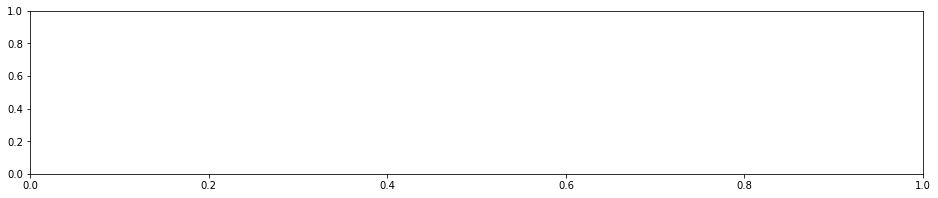

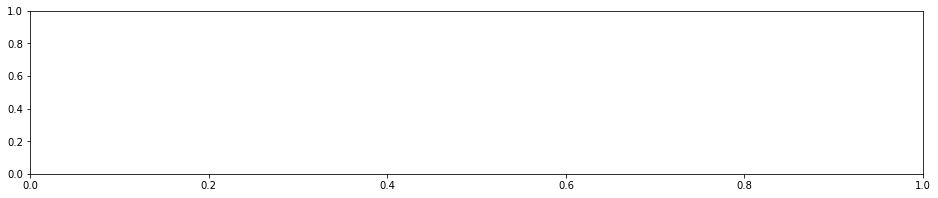

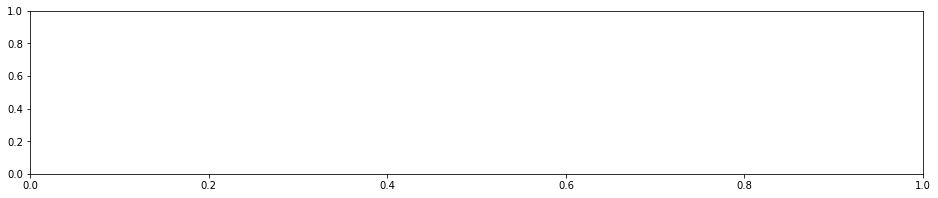

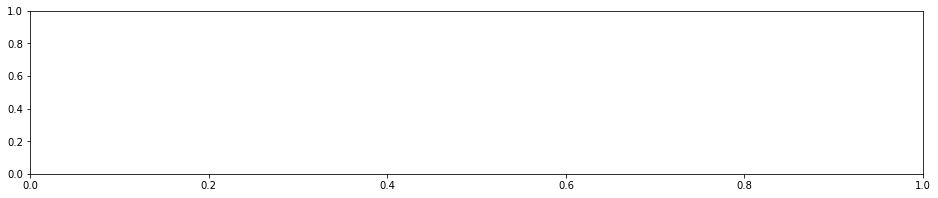

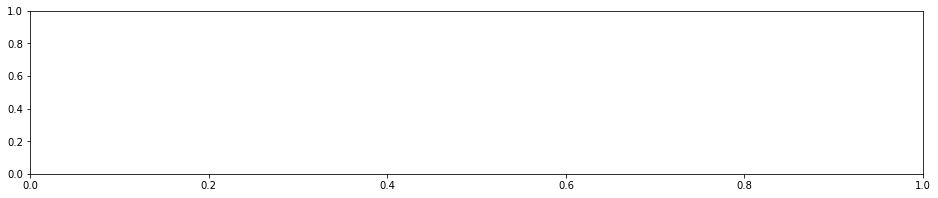

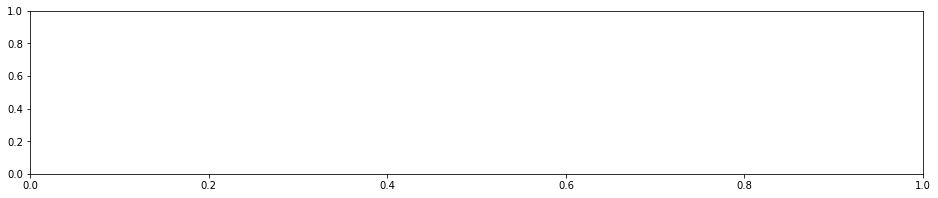

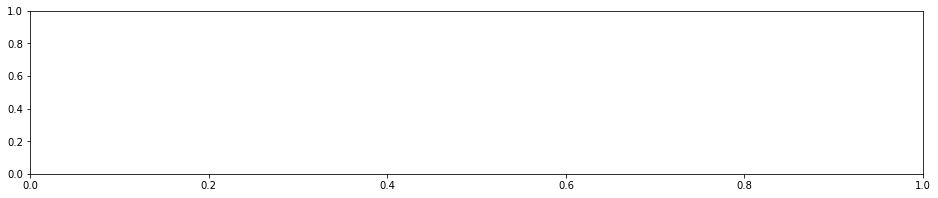

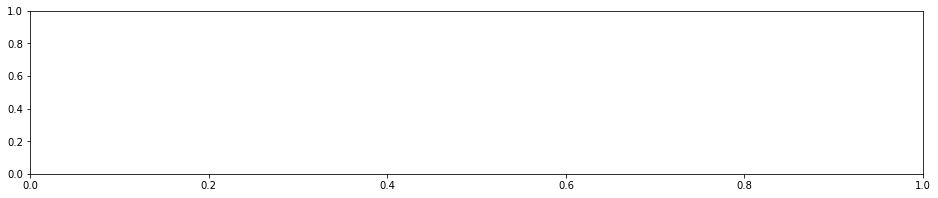

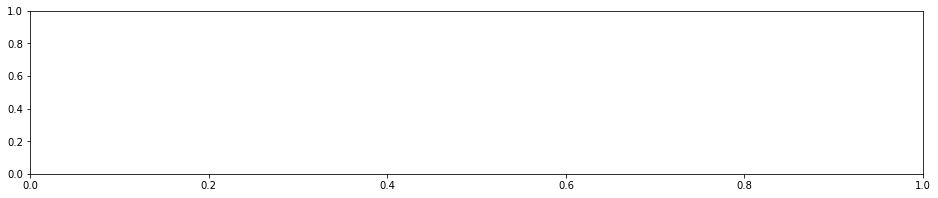

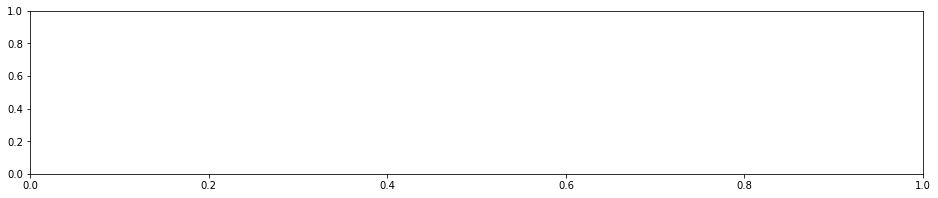

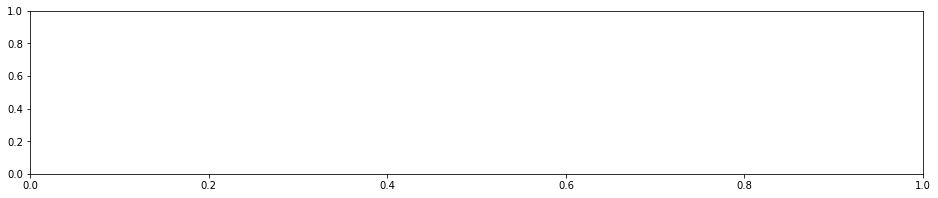

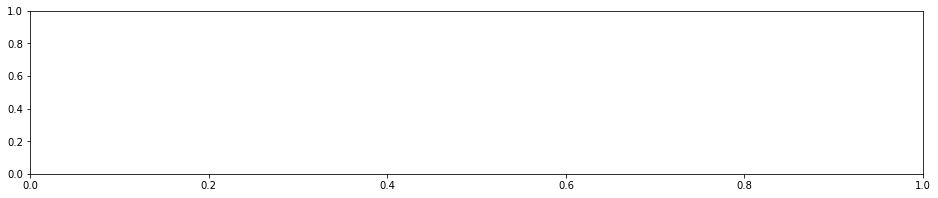

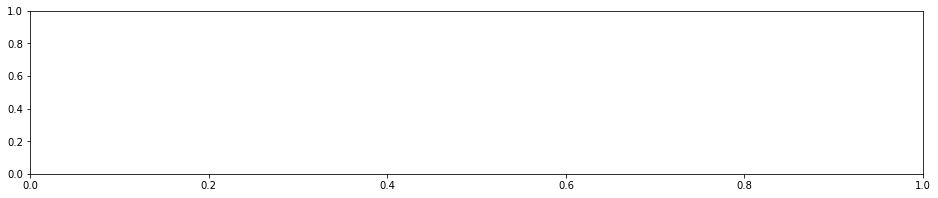

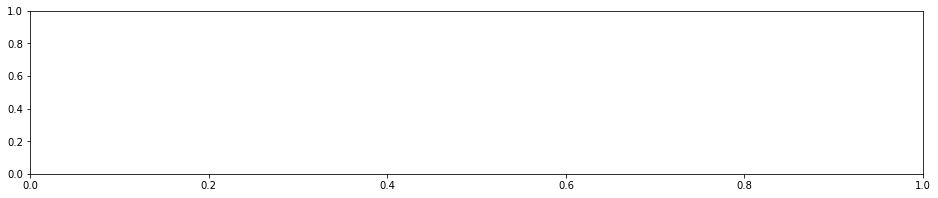

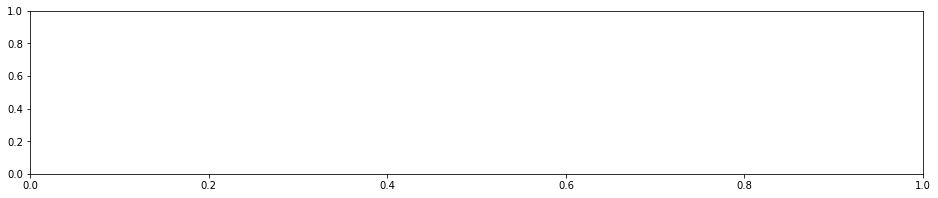

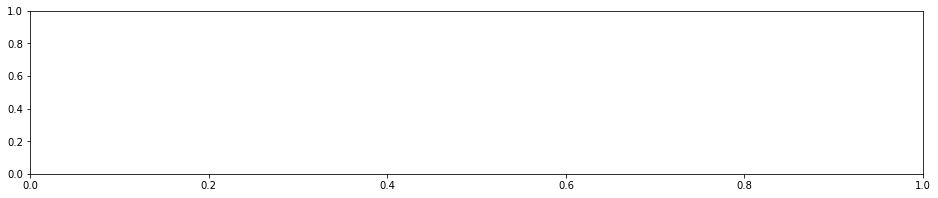

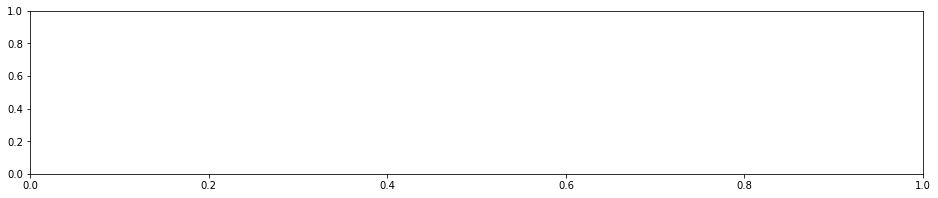

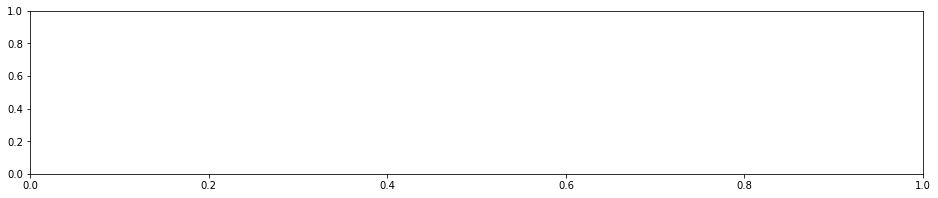

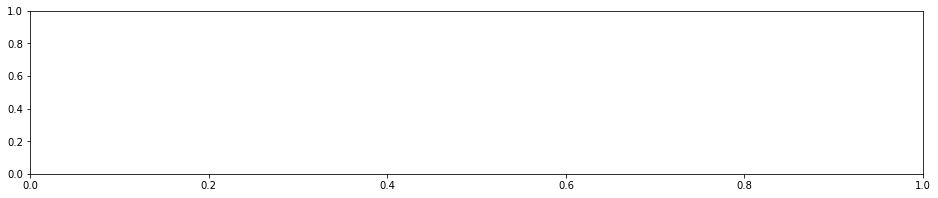

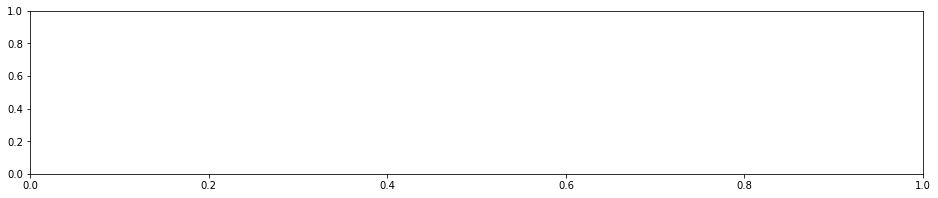

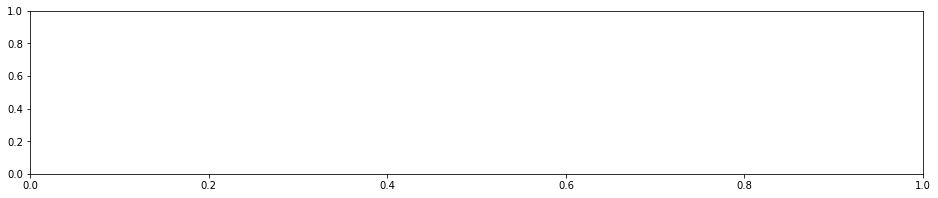

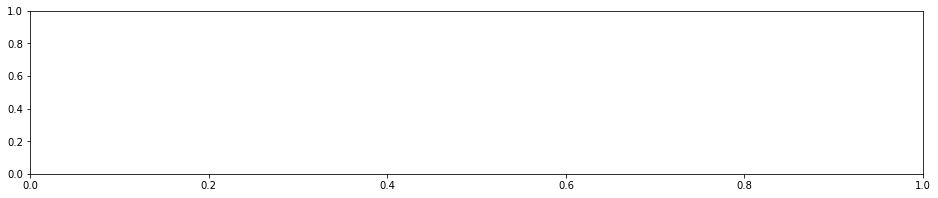

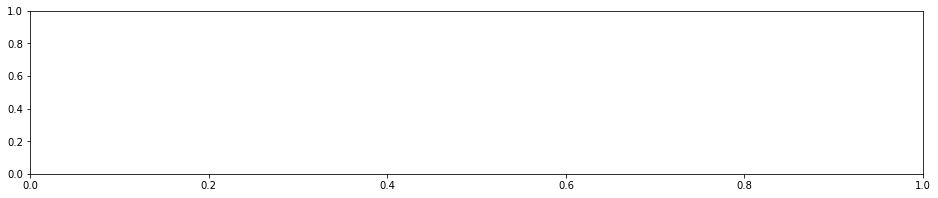

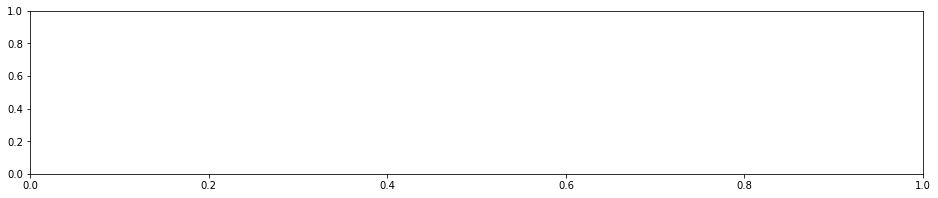

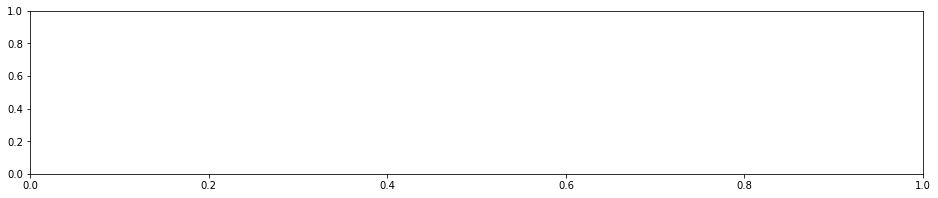

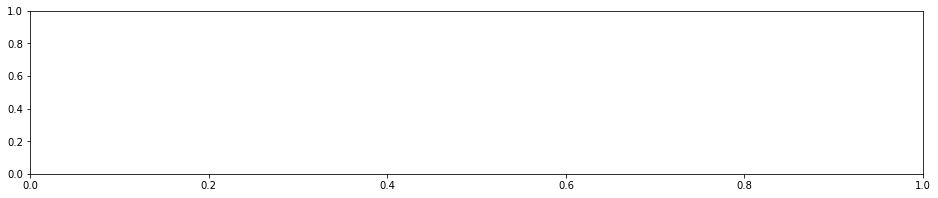

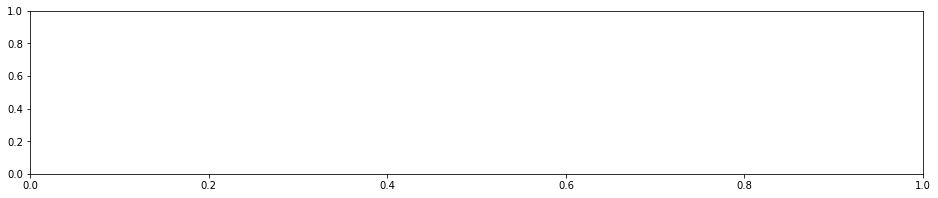

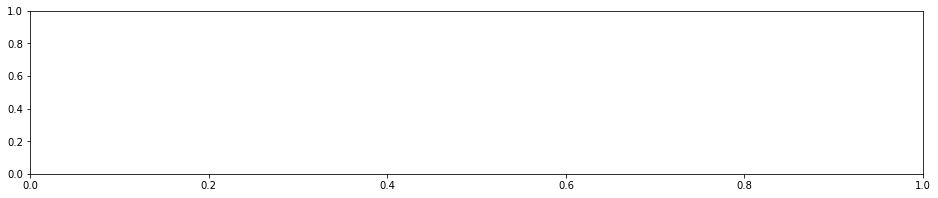

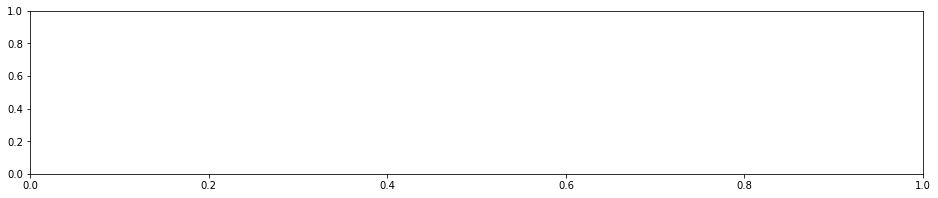

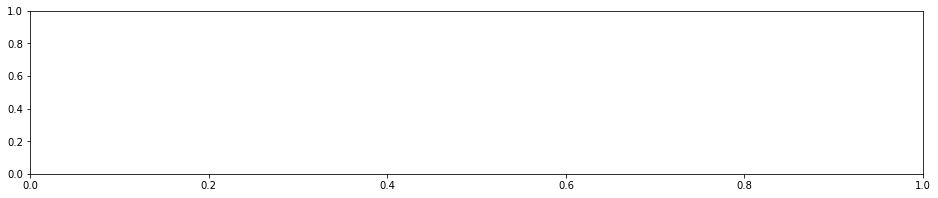

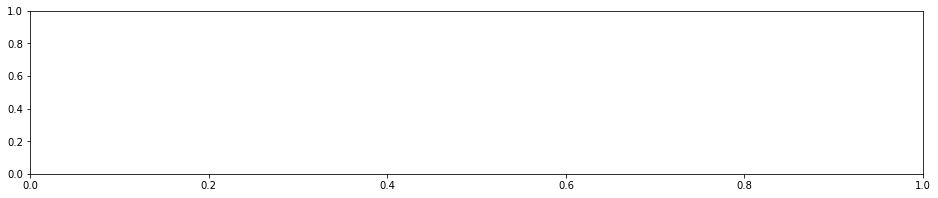

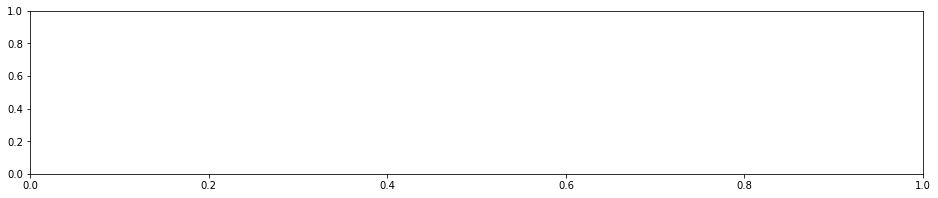

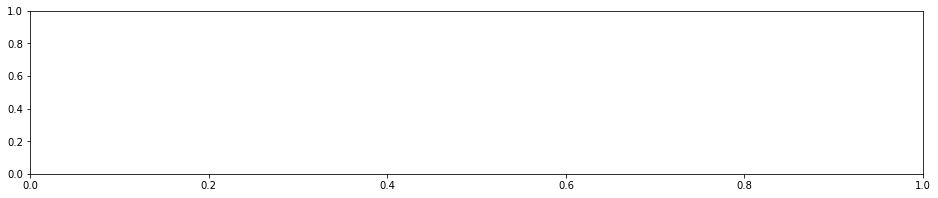

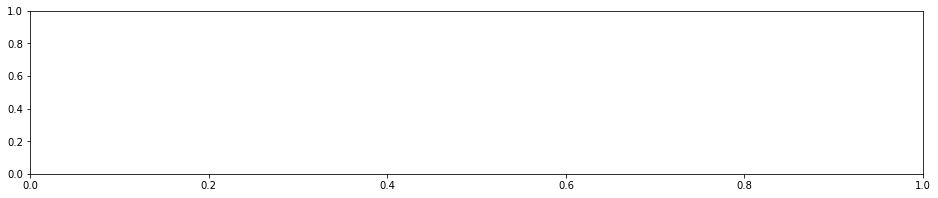

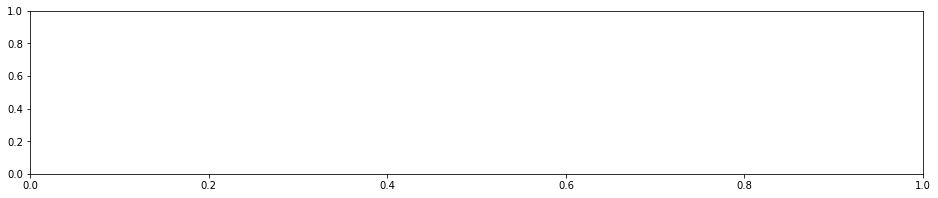

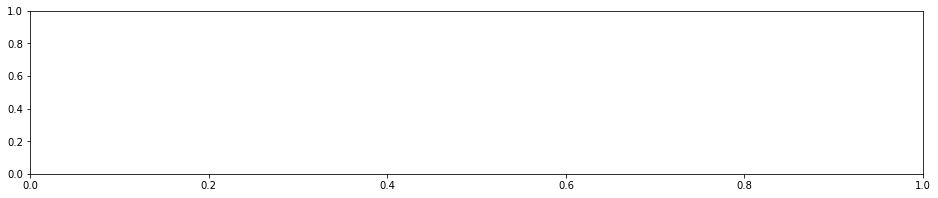

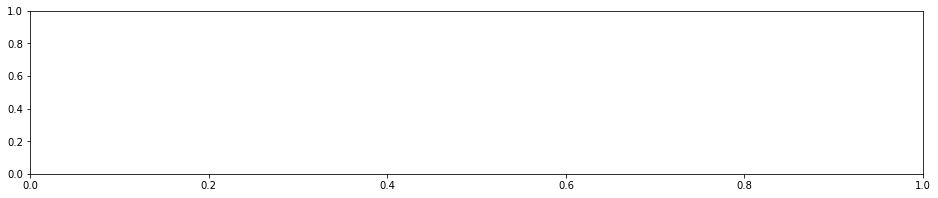

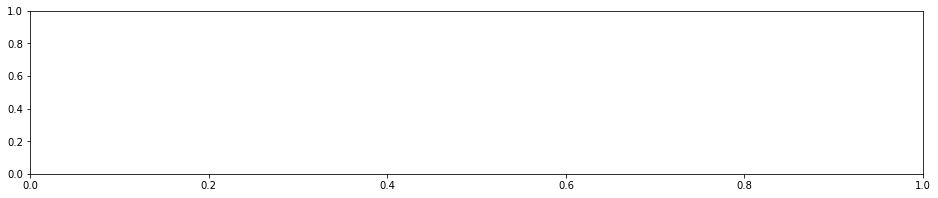

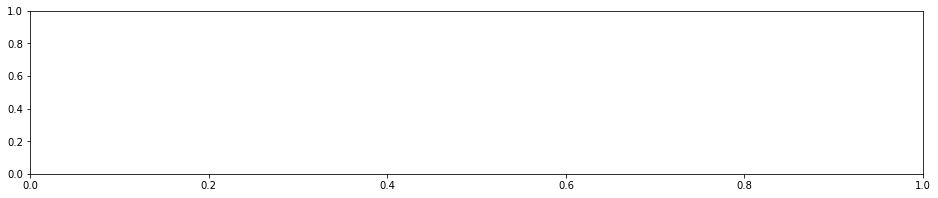

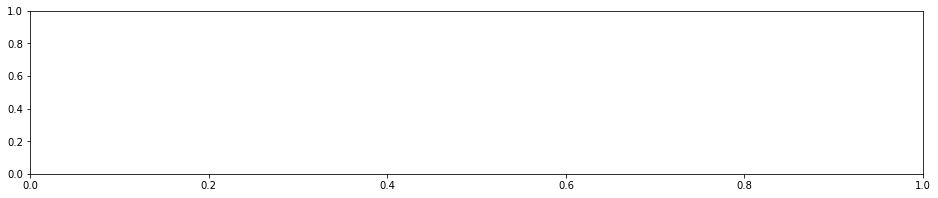

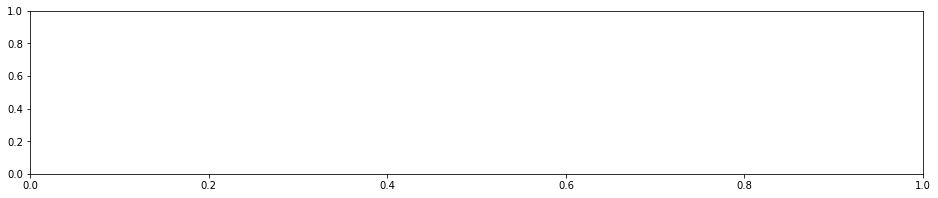

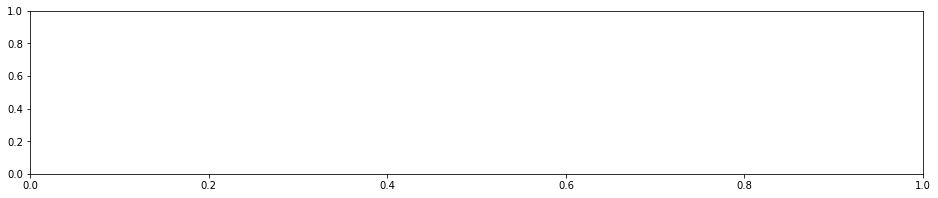

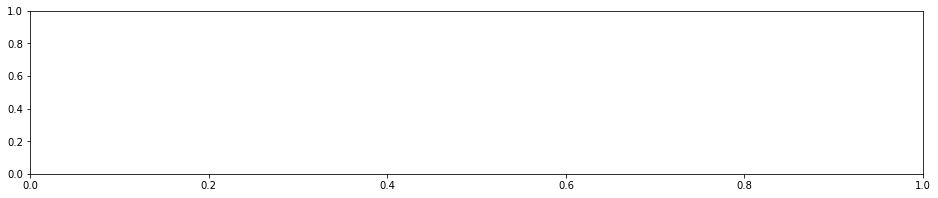

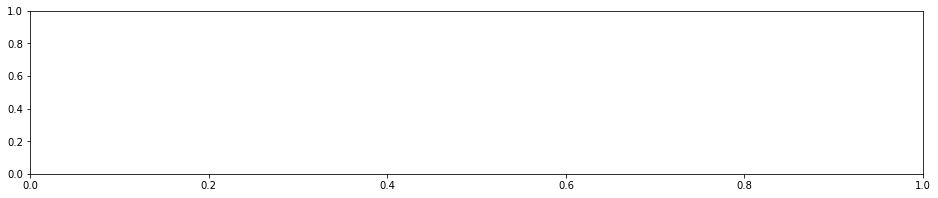

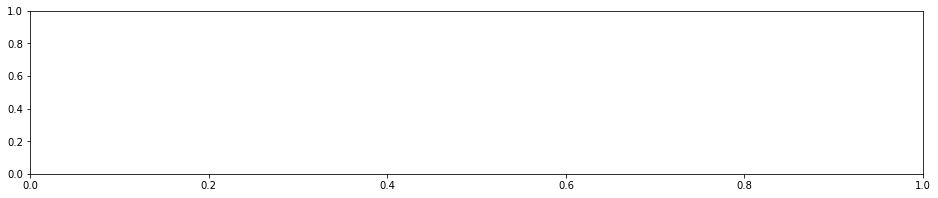

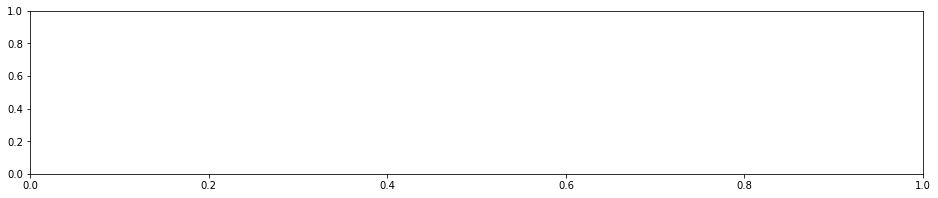

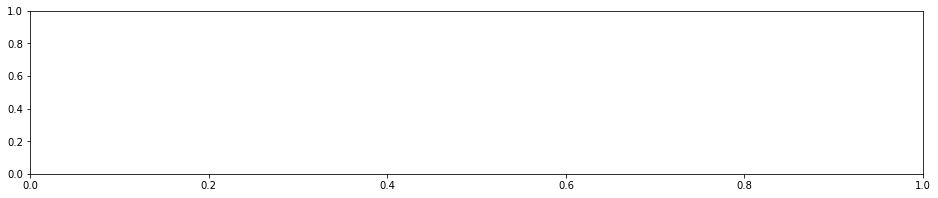

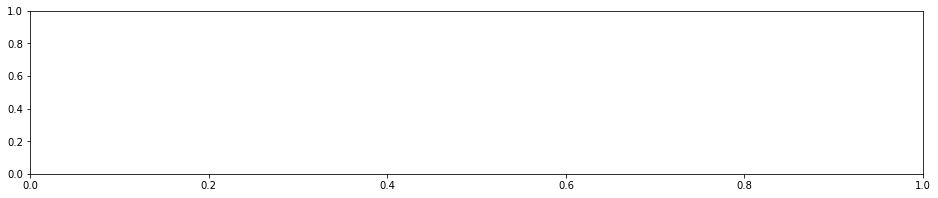

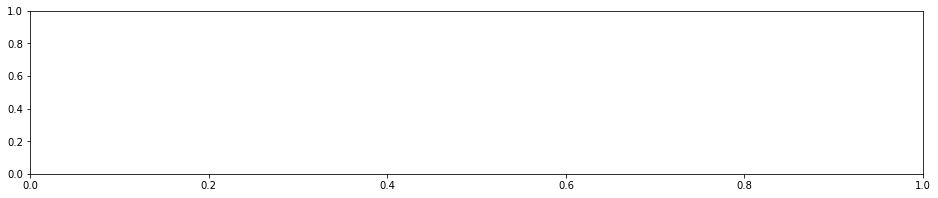

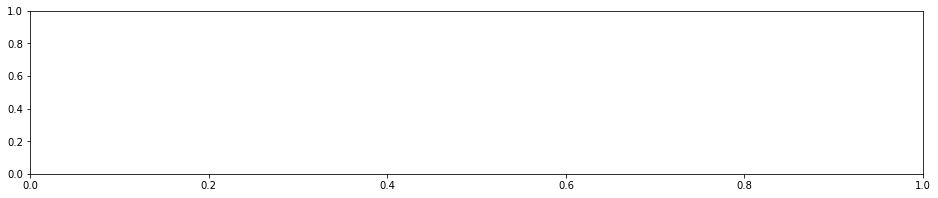

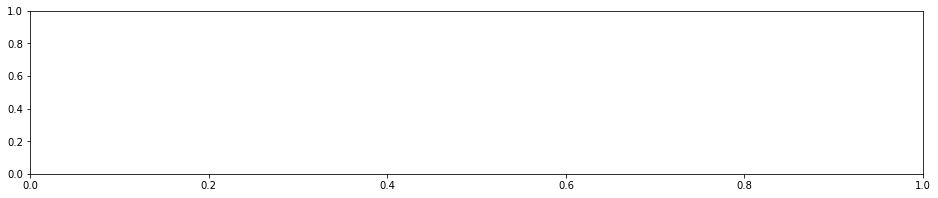

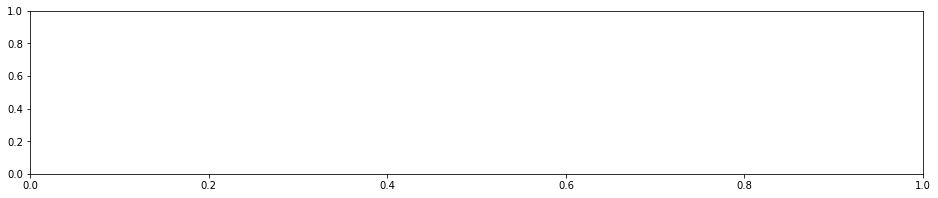

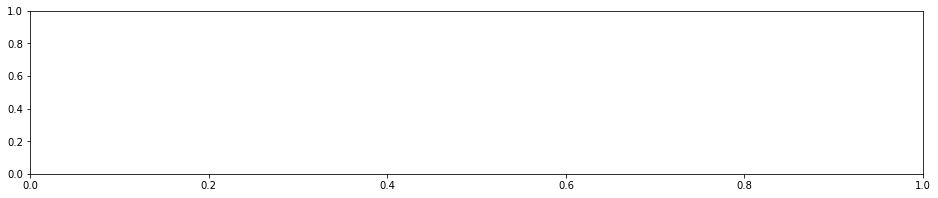

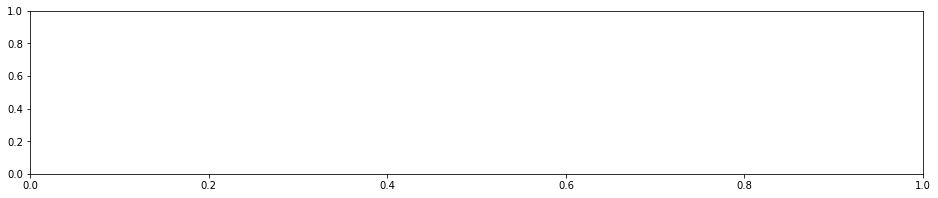

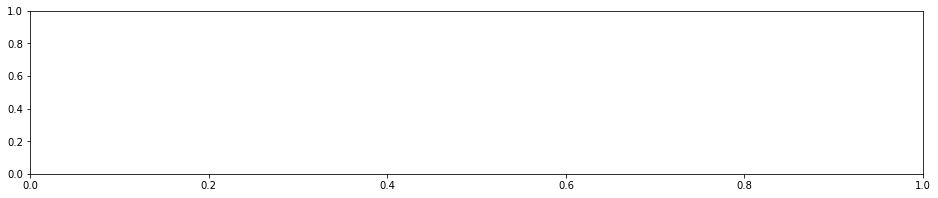

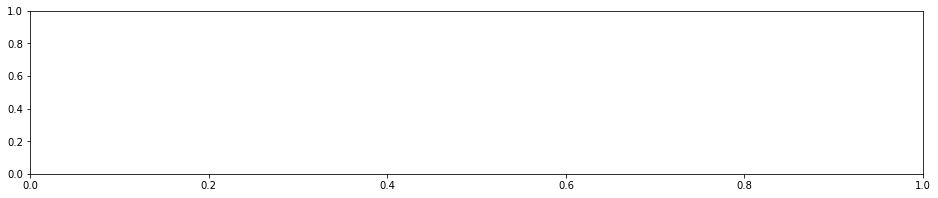

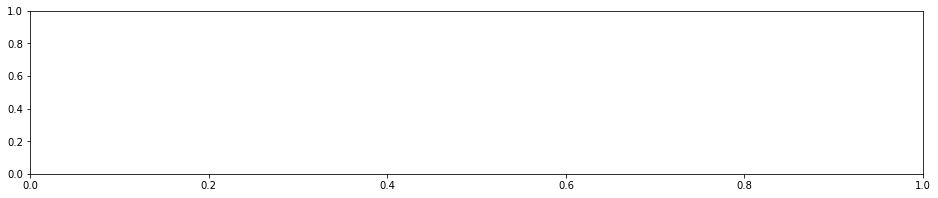

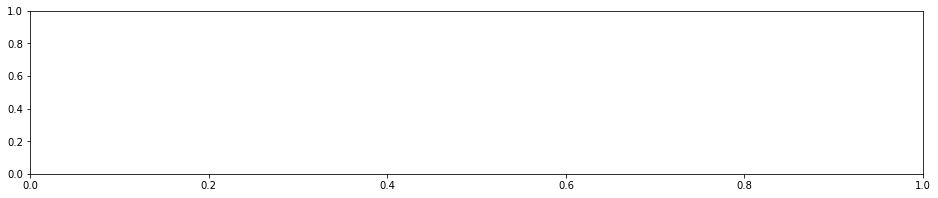

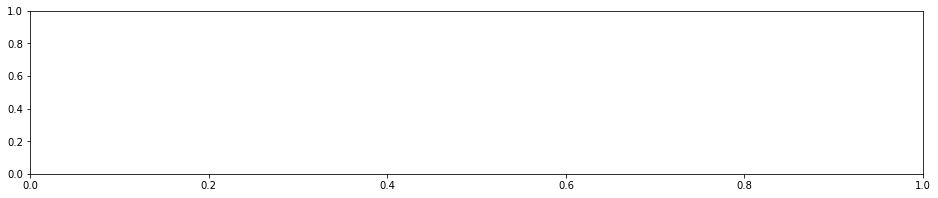

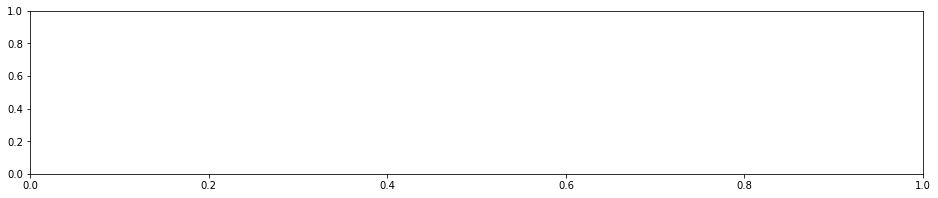

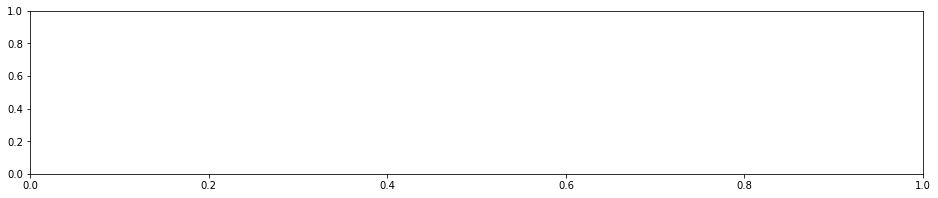

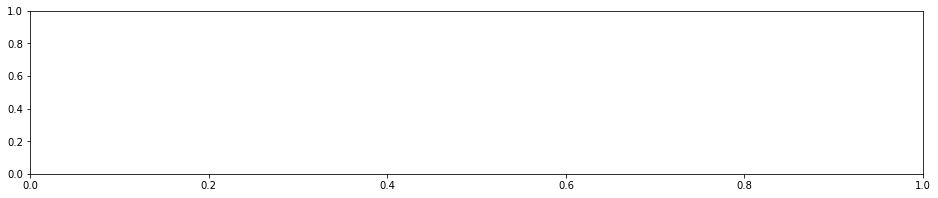

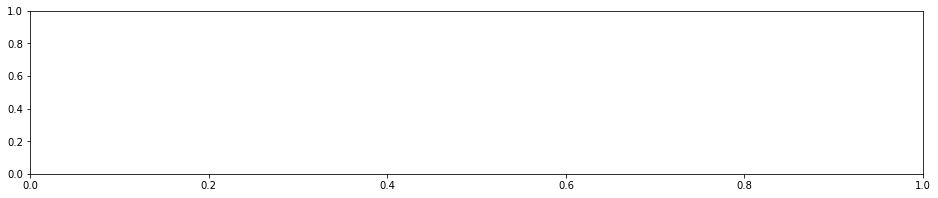

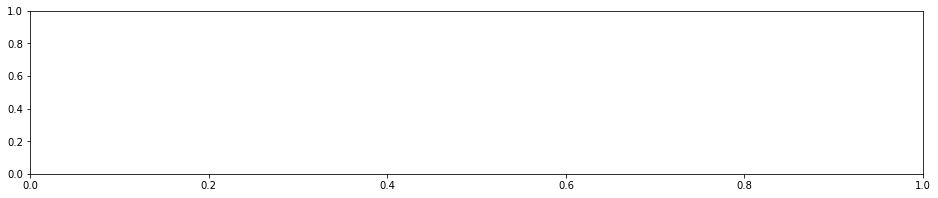

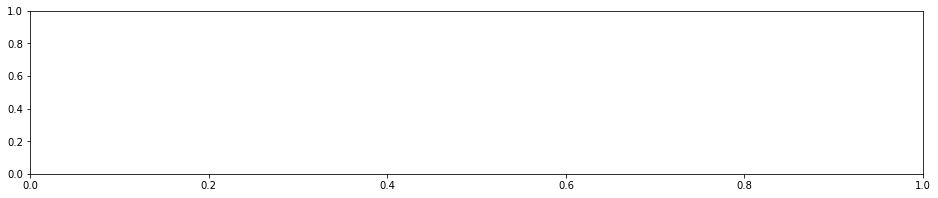

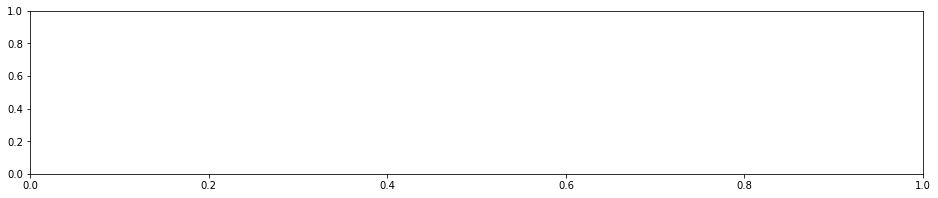

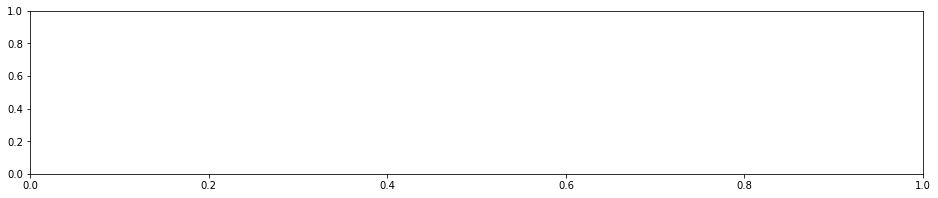

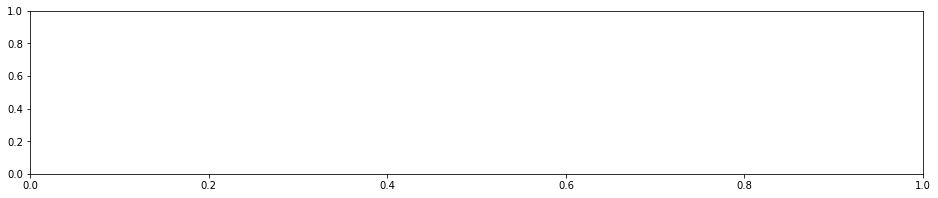

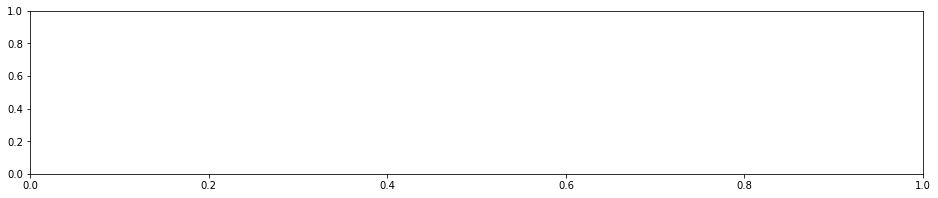

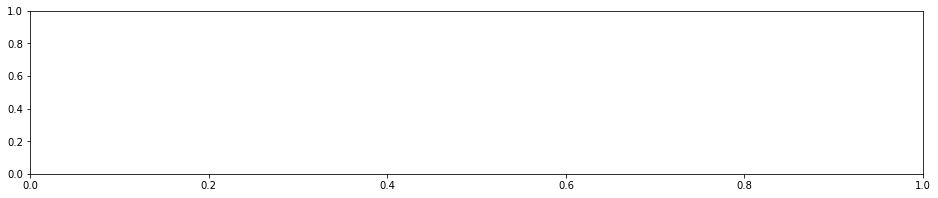

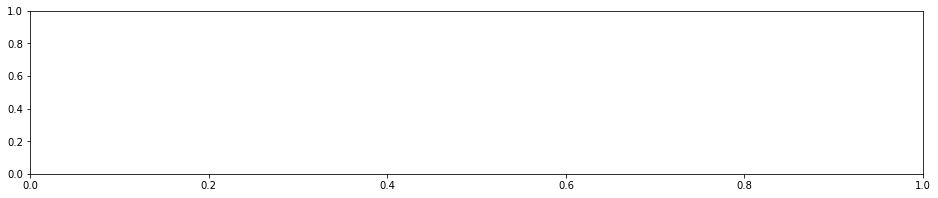

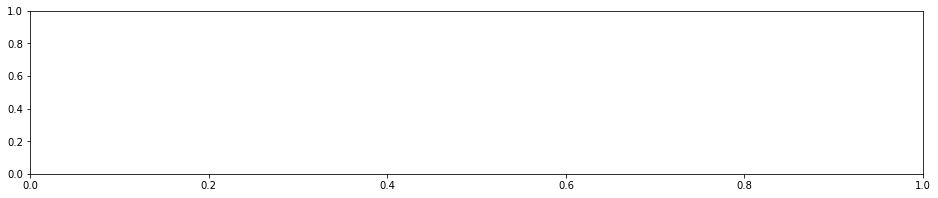

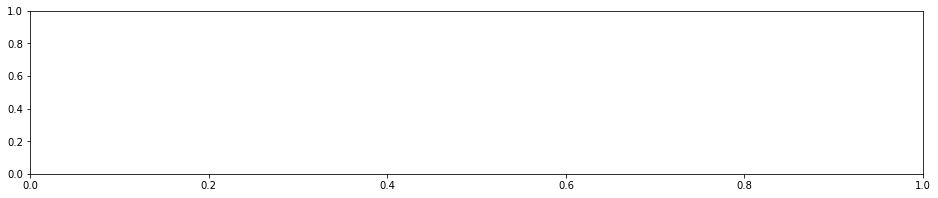

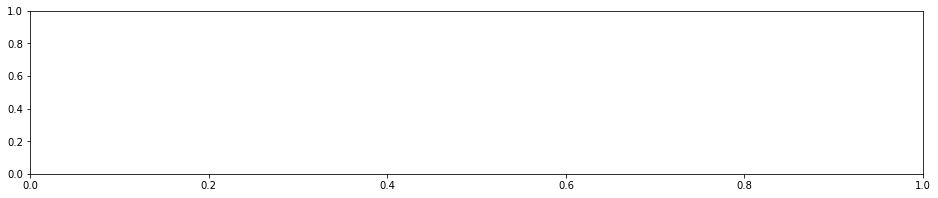

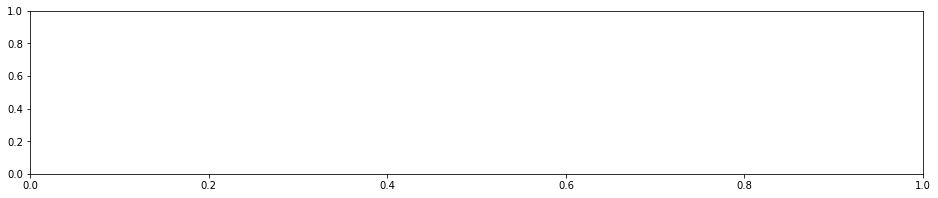

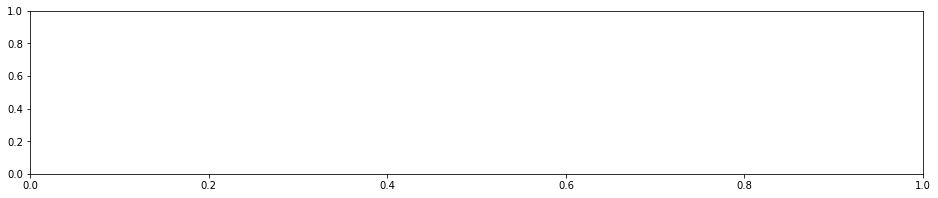

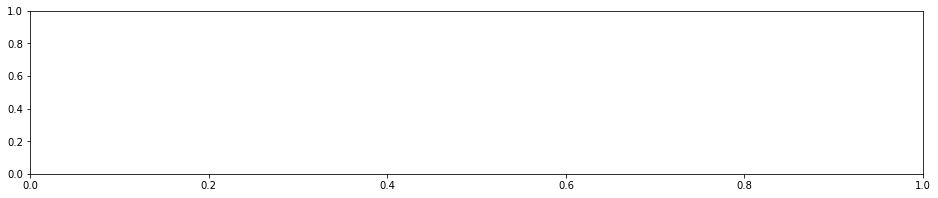

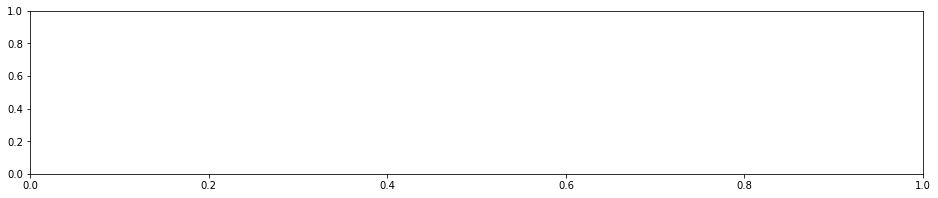

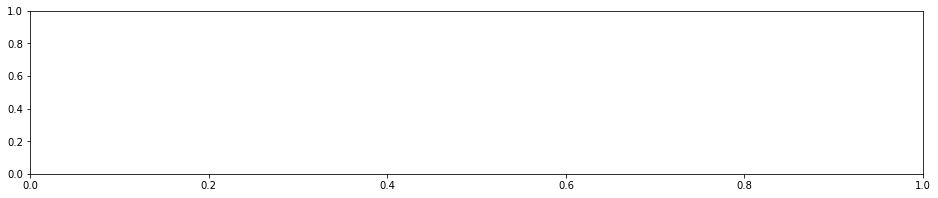

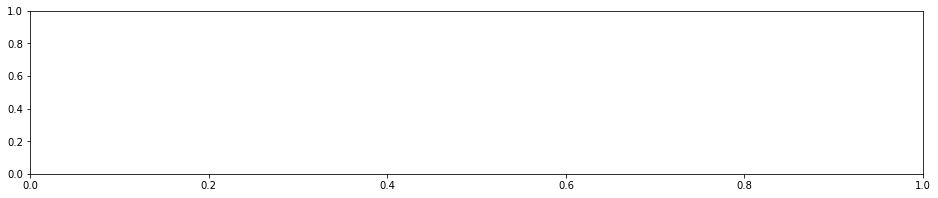

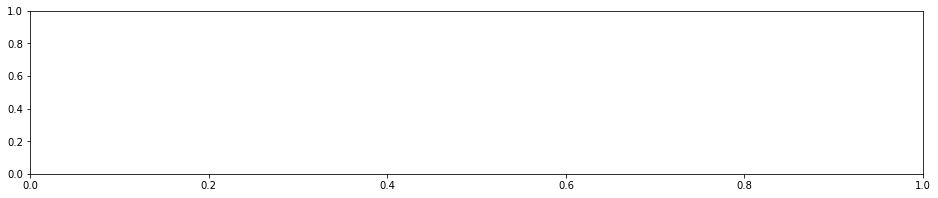

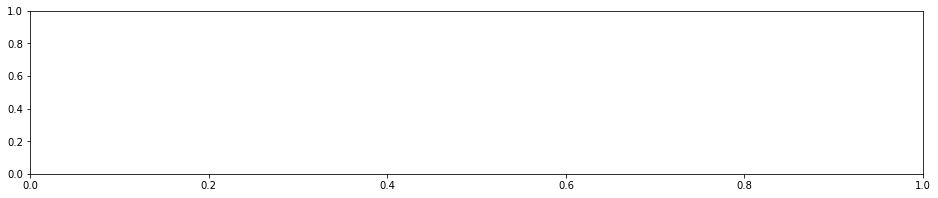

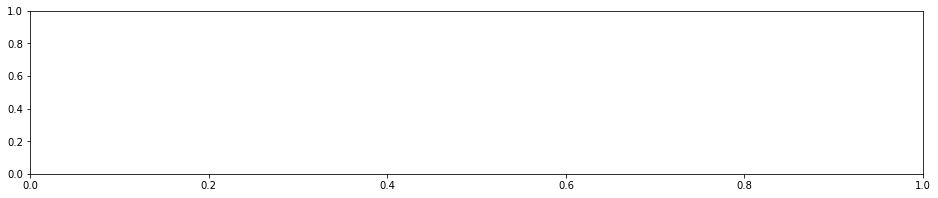

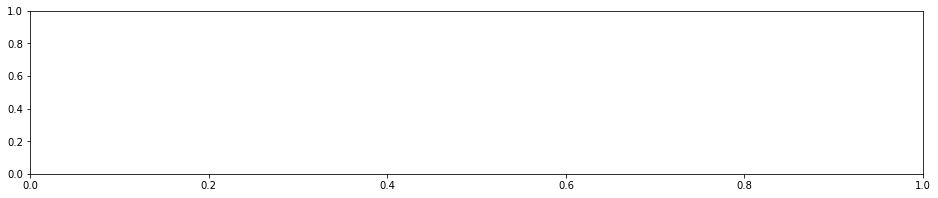

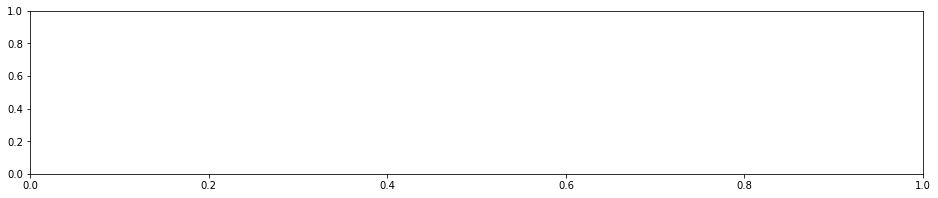

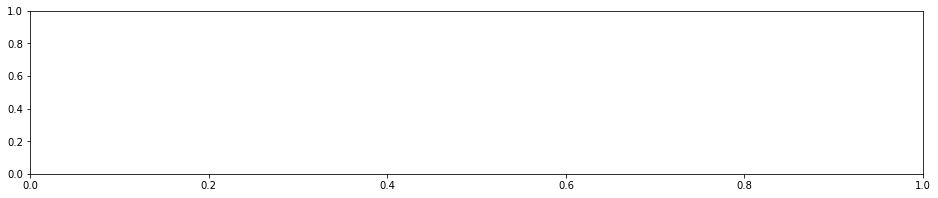

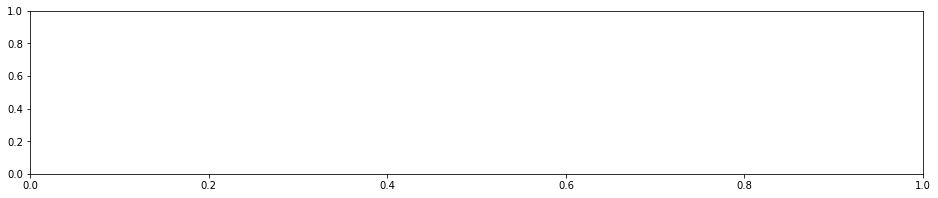

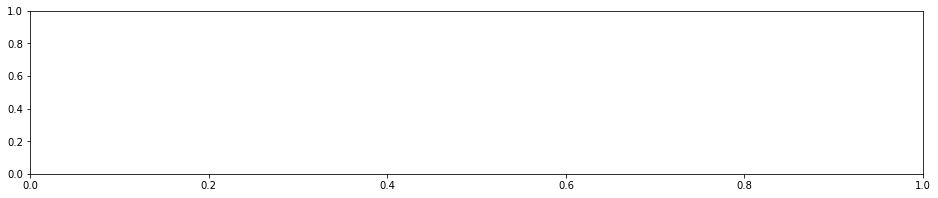

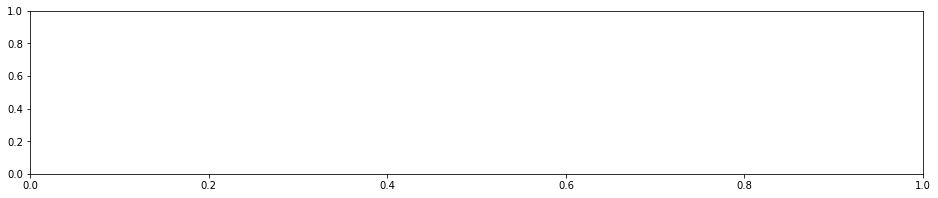

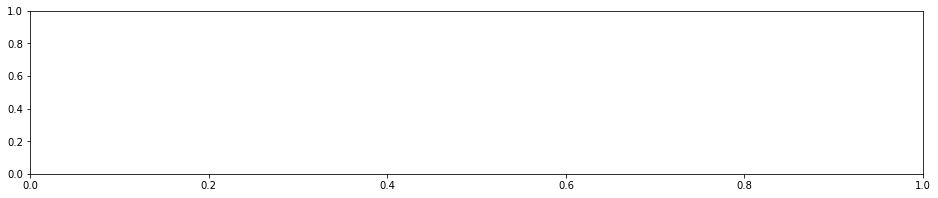

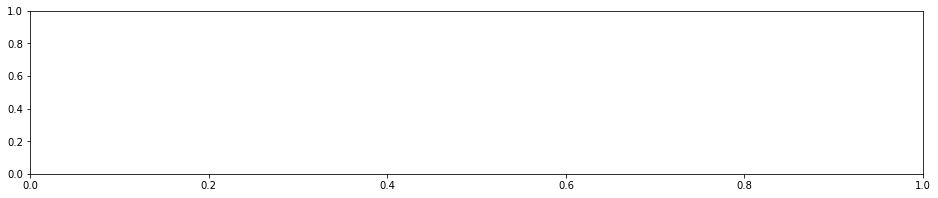

Error in callback <function flush_figures at 0x000001542982A0D0> (for post_execute):


KeyboardInterrupt: 

In [46]:
from IPython import display
for i in range(a0_n):
    for j in range(nu_n):
        for t in range(len(A[i][j].T)):
            acs = A[i][j][:Nx][:,t]
            ass = A[i][j][Nx:][:,t]
            if t % 10 == 0:
                display.clear_output(wait=True)
                figure(figsize = (16,3))
                plot(xs,acs)
                plot(xs,ass)
                #axvline(sol.y[0][t], color = "tab:green")
                #text(-10,0.2,r"$\tau$ = " +str(round(sol.t[t])))
                #ylim(0,a0*1.1)
                xlabel("Position", fontsize = 16)
                ylabel("Concentration", fontsize = 16)
                display.display(gcf())
        
                cla()

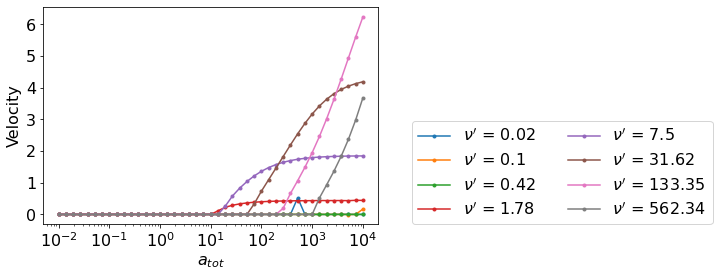

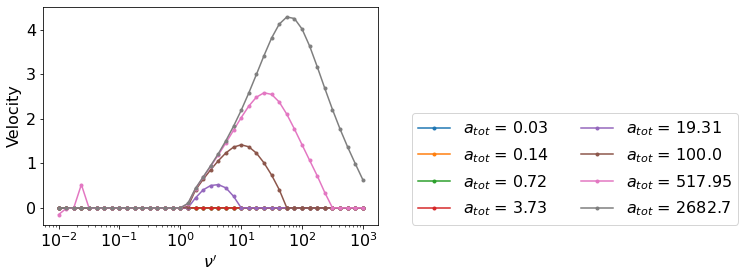

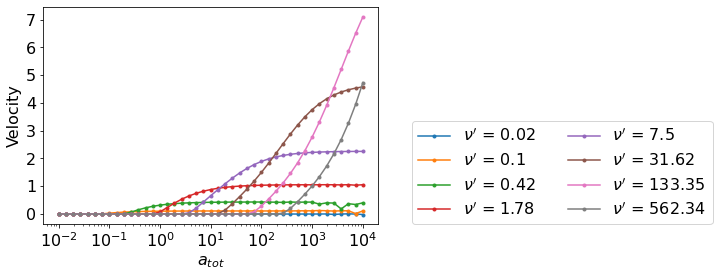

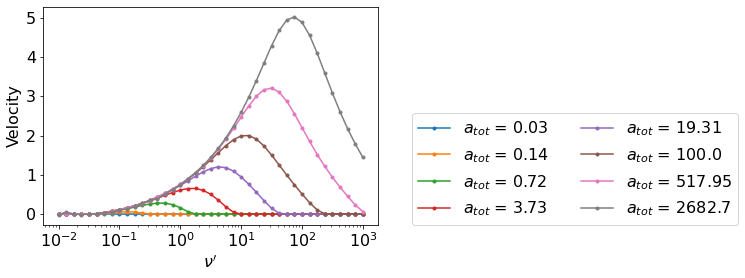

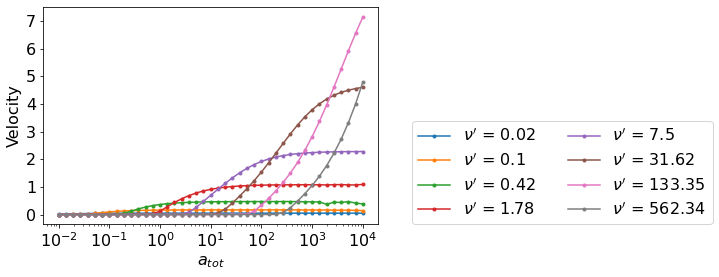

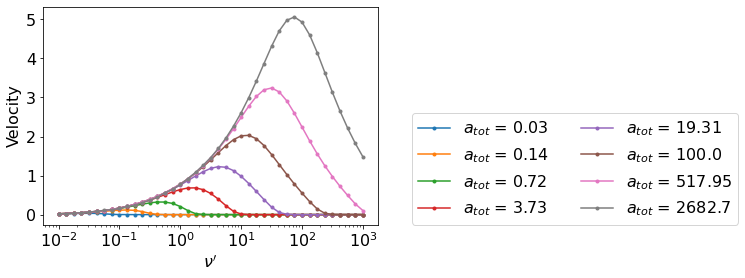

In [79]:
for i in range(dG_n):
    if i == dGs[0]:
        amin, amax,numin,numax = -2, 4, -2, 3
    elif i == dGs[1]:
        amin, amax,numin,numax = -2, 4, -2, 3
    else:
        amin, amax,numin,numax = -2, 4, -2, 3
    a0s = logspace(amin,amax,43, base = 10)
    a0_n = len(a0s)
    nus = logspace(numin,numax,41, base = 10)
    nu_n = len(nus)
    for j in range(3,nu_n,5):
        plot(a0s,vs[i].T[j],".-", label= r"$\nu'$ = "+ str(round(nus[j],2)))
        xscale("log")
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
    xlabel(r"$a_{tot}$", fontsize = 16)
    ylabel("Velocity", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    show()
    for j in range(3,a0_n,5):
        plot(nus,vs[i][j],".-", label= r"$a_{tot}$ = "+ str(round(a0s[j],2)))
        xscale("log")
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
    xlabel(r"$\nu'$", fontsize = 16)
    ylabel("Velocity", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    show()

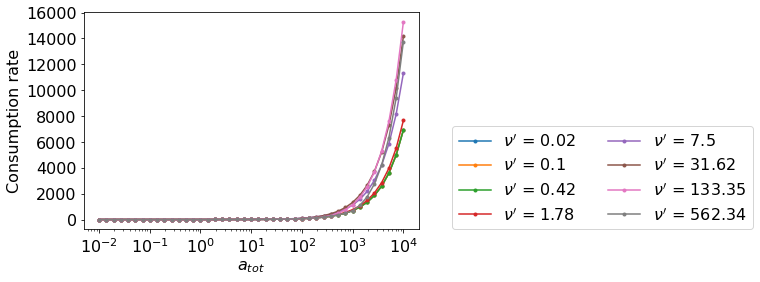

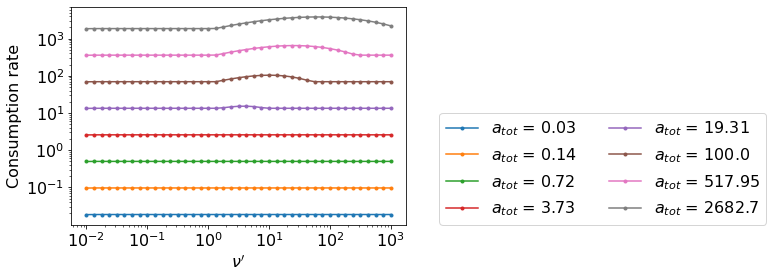

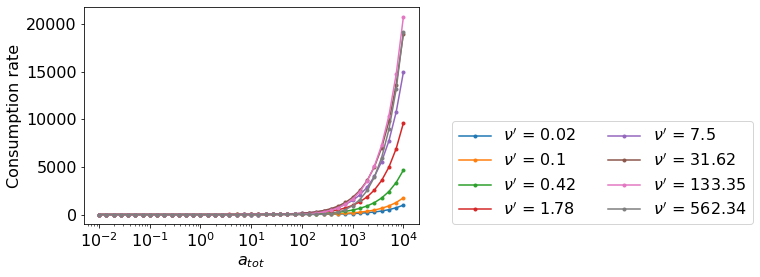

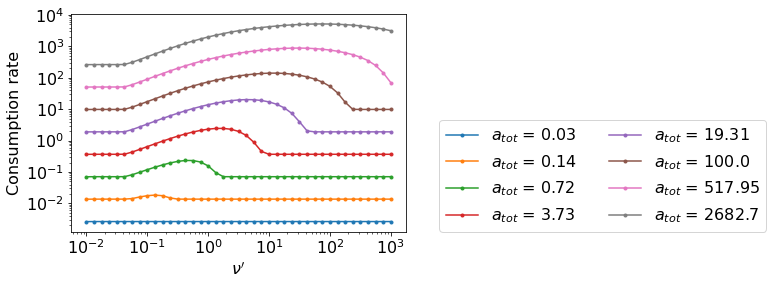

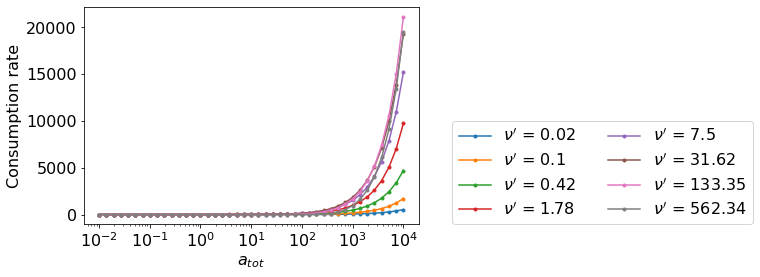

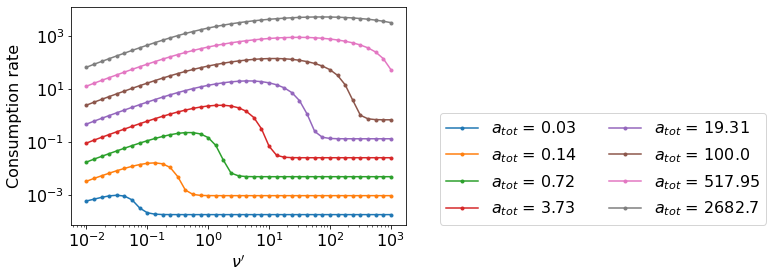

In [80]:
for i in range(dG_n):
    if i == dGs[0]:
        amin, amax,numin,numax = -2, 4, -2, 3
    elif i == dGs[1]:
        amin, amax,numin,numax = -2, 4, -2, 3
    else:
        amin, amax,numin,numax = -2, 4, -2, 3
    a0s = logspace(amin,amax,43, base = 10)
    a0_n = len(a0s)
    nus = logspace(numin,numax,41, base = 10)
    nu_n = len(nus)
    for j in range(3,nu_n,5):
        plot(a0s,burnt[i].T[j],".-", label= r"$\nu'$ = "+ str(round(nus[j],2)))
        xscale("log")
        #yscale("log")
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
    xlabel(r"$a_{tot}$", fontsize = 16)
    ylabel("Consumption rate", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    show()
    for j in range(3,a0_n,5):
        plot(nus,burnt[i][j],".-", label= r"$a_{tot}$ = "+ str(round(a0s[j],2)))
        xscale("log")
        yscale("log")
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
    xlabel(r"$\nu'$", fontsize = 16)
    ylabel("Consumption rate", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    show()

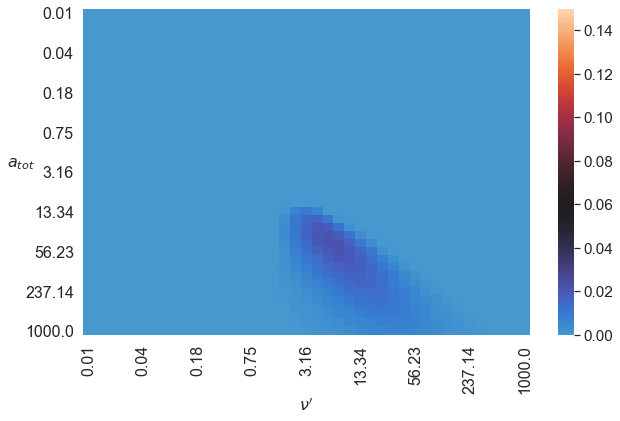

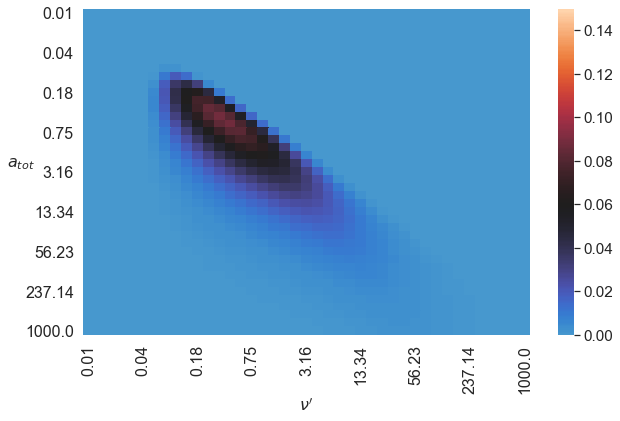

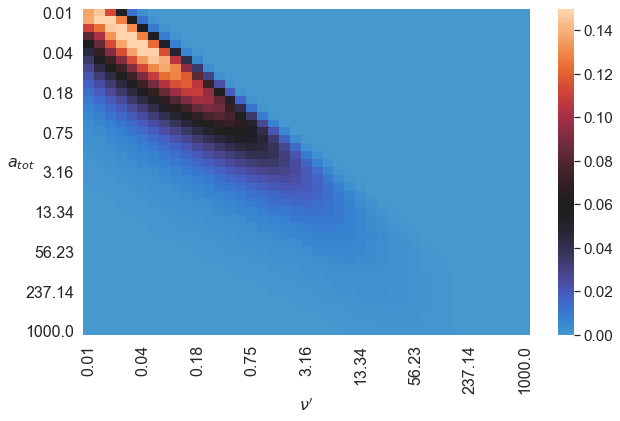

In [15]:
for i in range(dG_n):
    factor = 1/dGs[i]
    a0stmp = []
    for j in range(a0_n):
        if j % 1 == 0:
            a0stmp.append(round(a0s[j],2)) 
        else:
            a0stmp.append("") 
    nustmp = []
    for j in range(nu_n):
        if j % 1 == 0:
            nustmp.append(round(nus[j],2))
        else:
            nustmp.append("")
    if i == 0:
        for j in range(a0_n):
            for k in range(nu_n):
                if (factor*vs[i]**2/burnt[i])[j][k] > 0.03:
                    vs[i][j][k] = 0.0
        
    figure(figsize = (10,6))
    sb.set(font_scale=1.4)
    df = pd.DataFrame(factor*vs[i]**2/burnt[i],index = a0stmp,  columns=nustmp)
    sb.heatmap(df, xticklabels = 5, yticklabels = 5, vmin = 0.0, vmax = 0.15, center = 0.06)
    ylabel(r"$a_{tot}$",rotation=0,fontsize = 16)
    xlabel(r"$\nu'$",fontsize = 16)
    yticks(rotation = 0,fontsize = 16) 
    xticks(rotation = 90,fontsize = 16) 
    show()

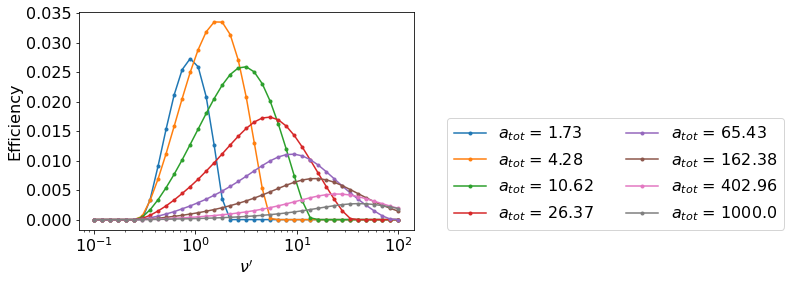

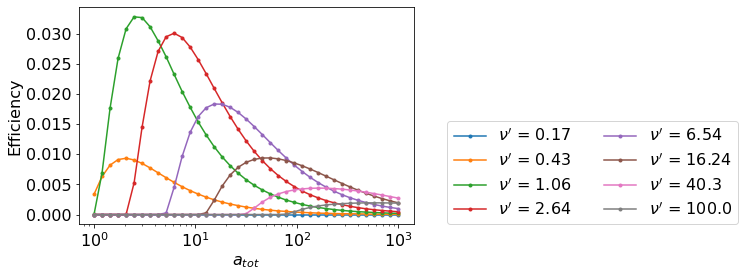

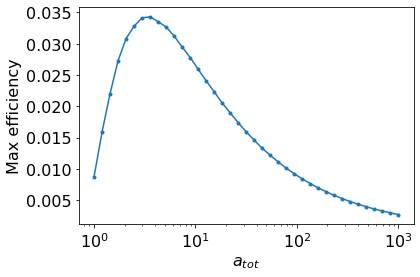

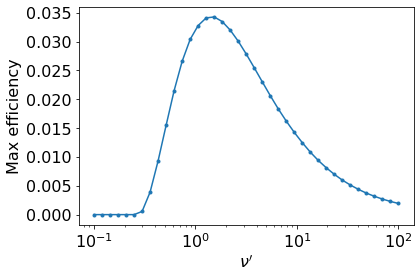

In [63]:
for i in range(3,a0_n,5):
    plot(nus,factor*vs[i]**2/burnt[i],".-", label= r"$a_{tot}$ = "+ str(round(a0s[i],2)))
    xscale("log")
    xlabel(r"$\nu'$", fontsize = 16)
    ylabel("Efficiency", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
show()


for i in range(3,nu_n,5):
    plot(a0s,factor*vs.T[i]**2/burnt.T[i],".-", label= r"$\nu'$ = "+ str(round(nus[i],2)))
    xscale("log")
    legend(loc = (1.1,0),fontsize = 16, ncol = 2)
    ylabel("Efficiency", fontsize = 16)
    xlabel(r"$a_{tot}$", fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
show()

etamaxnu = []
etamaxa0 = []
for i in range(a0_n):
    etamaxa0.append(max(factor*vs[i]**2/burnt[i]))
for i in range(nu_n):
    etamaxnu.append(max(factor*vs.T[i]**2/burnt.T[i]))

plot(a0s,etamaxa0,".-")
xscale("log")
ylabel("Max efficiency", fontsize = 16)
xlabel(r"$a_{tot}$", fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)
show()

plot(nus,etamaxnu,".-")
xscale("log")
ylabel("Max efficiency", fontsize = 16)
xlabel(r"$\nu'$", fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)
show()

In [55]:
def derivs1(t, y, nu, xAs):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Acx = y[1:N+1]          # bound complex on lattice
    Ax = y[-N:]             # free complex on lattice
    
    dxcdt = integrate.trapz(-(x0-xAs)*Acx, x=xAs)  # force equation
    binding = exp(-0.5*(x0-xAs)**2)*Ax 
    burnt = nu*Acx

    dAcxdt = (binding - burnt)   # complex chemistry
    dAxdt = -binding            # free substrate chemistry
    
    return array( [dxcdt] + list(dAcxdt) + list(dAxdt))     # maybe a better way to put them all together
vs1 = []  # record final speed and burn rate
burnt1 = []
for a0 in a0s:
    
    A0x = zeros(Nx)
    A0x[xAs > 0.0] = a0
    vtmp = []
    btmp = []
    for nu in nus:
        print(a0, nu)

        x0 = 0.0
        Ax = 1.0*A0x
        Acx = zeros(Nx)

        # initial conditions for all the equations, y0
        y0 = array([x0] + list(Acx) + list(Ax))

        sol = integrate.solve_ivp(lambda t, y: derivs1(t, y, nu, xAs), (0., tf), y0, events=[event], method='BDF')

        speed = derivs1(sol.t[-1], sol.y[:,-1], nu, xAs)[0]  #dx/dt
        vtmp.append(speed)
        
        Acxf = sol.y[1:1+Nx,-1]  # final amount of complex
        btot = integrate.trapz(nu*Acxf, x=xAs)    # total rate of burnt at final time 
        btmp.append(btot)
        
    vs1.append(vtmp)
    burnt1.append(btmp)
vs1 = array(vs1)
burnt1 = array(burnt1)

NameError: name 'xAs' is not defined

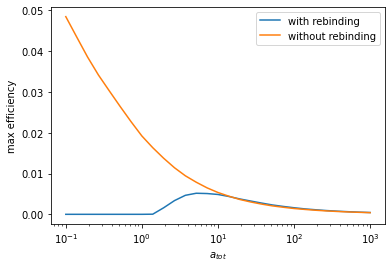

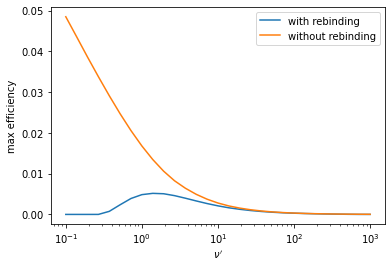

In [126]:
etamaxnu1 = []
for i in range(0,a0_n):
    etamaxnu1.append(max(factor*vs1[i]**2/burnt1[i]))
plot(nus,etamaxnu, label = "with rebinding")
plot(nus,etamaxnu1, label = "without rebinding")
xscale("log")
xlabel("$a_{tot}$")
ylabel("max efficiency")
legend()
show()
etamaxa01 = []
for i in range(0,nu_n):
    etamaxa01.append(max(factor*vs1.T[i]**2/burnt1.T[i]))
plot(a0s,etamaxa0, label = "with rebinding")
plot(a0s,etamaxa01, label = "without rebinding")
xscale("log")
xlabel(r"$\nu'$")
ylabel("max efficiency")
legend()
show()